# Data Analysis

## Setup

Import required modules

In [1]:
import numpy as np
import pandas as pd
import torch
from pathlib import Path

import pyro
import pyro.distributions as dist
from pyro.ops.stats import hpdi
from pyro.infer import Predictive

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from tapqir.models import Cosmos, HMM
from tapqir.imscroll.glimpse_reader import GlimpseDataset
from tapqir.utils.imscroll import count_intervals, time_to_first_binding, \
    association_rate, dissociation_rate, bootstrap, posterior_estimate, \
    bound_dwell_times, unbound_dwell_times, sample_and_bootstrap

from tapqir.utils.stats import ci_from_trace
from tapqir.utils.mle_analysis import train, double_exp_model, double_exp_guide, ttfb_model, ttfb_guide

### Load results

In [2]:
path_data = Path("/shared/centaur/data/GraceArticlePol2/")
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs16"

# glimpse = GlimpseDataset(path_data)

# load parameters
model = Cosmos(S=1, K=2)
model.load(path_data, True, "cpu")
model.load_parameters(path_params)

In [3]:
fit = pd.read_csv(
            path_params / "statistics.csv",
            squeeze=True,
            index_col=0
        ).rename("GraceArticlePol2")
fit

snr                    1.609228
gain_mean              6.427659
gain_ll                6.427659
gain_ul                6.427659
pi_mean                0.114180
pi_ll                  0.114180
pi_ul                  0.114180
lamda_mean             0.319613
lamda_ll               0.319613
lamda_ul               0.319613
proximity_mean         0.575463
proximity_ll           0.575463
proximity_ul           0.575463
MCC                    0.847510
Recall                 0.787219
Precision              0.951754
TN                225007.000000
FP                  1400.000000
FN                  7465.000000
TP                 27618.000000
z_median               0.924981
z_ll                   0.154526
z_ul                   0.962701
Name: GraceArticlePol2, dtype: float64

NameError: name 'y_pos' is not defined

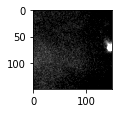

In [5]:
for f in [1]:
    #frame = model.data.drift.index[f]
    plt.figure(figsize=(1.45, 1.45))

    # plot selected area of the image
    plt.imshow(glimpse[f][197:347, 202:352], cmap="gray",
               vmin=600, vmax=1100)
    # on-target area
    plt.gca().add_patch(Rectangle((y_pos, x_pos), model.data.D, model.data.D,
                                  edgecolor="#AA3377", lw=2, facecolor="none"))

    # off-target area
    plt.gca().add_patch(Rectangle((y_pos2, x_pos2), model.data.D, model.data.D,
                                  edgecolor="#CCBB44", lw=2, facecolor="none"))

    plt.xticks([], [])
    plt.yticks([], [])
    plt.savefig(f"/tmp/frame{f}.png", dpi=600)
    plt.show()

In [12]:
x_pos, y_pos

NameError: name 'x_pos' is not defined

### Figure 1

In [4]:
ontarget = 163
offtarget = 282
frames = [625, 630, 635, 640, 645]
vmin, vmax = 340, 635

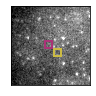

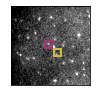

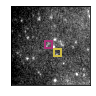

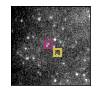

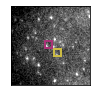

In [17]:
for f in frames:
    frame = model.data.drift.index[f]
    plt.figure(figsize=(1.45, 1.45))

    # plot selected area of the image
    plt.imshow(glimpse[frame][200:350, 630:780], cmap="gray",
               vmin=vmin, vmax=vmax)

    # on-target area
    aoi = model.data.target.index[ontarget]
    y_pos = model.data.target.at[aoi, "abs_y"] + \
        model.data.drift.at[frame, "abs_dy"] - 8.5 - 630
    x_pos = model.data.target.at[aoi, "abs_x"] + \
        model.data.drift.at[frame, "abs_dx"] - 8.5 - 200
    plt.gca().add_patch(Rectangle((y_pos, x_pos), model.data.D, model.data.D,
                                  edgecolor="#AA3377", lw=2, facecolor="none"))

    # off-target area
    aoi = model.control.target.index[offtarget]
    y_pos2 = model.control.target.at[aoi, "abs_y"] + \
        model.control.drift.at[frame, "abs_dy"] - 8.5 - 630
    x_pos2 = model.control.target.at[aoi, "abs_x"] + \
        model.control.drift.at[frame, "abs_dx"] - 8.5 - 200
    plt.gca().add_patch(Rectangle((y_pos2, x_pos2), model.data.D, model.data.D,
                                  edgecolor="#CCBB44", lw=2, facecolor="none"))

    plt.xticks([], [])
    plt.yticks([], [])
    plt.savefig(f"/tmp/frame{f}.png", dpi=600)
    plt.show()

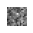

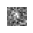

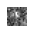

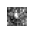

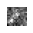

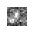

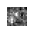

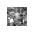

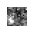

In [18]:
frames = [625, 628, 630, 633 , 635, 638, 640, 643, 645]

for f in frames:
    plt.figure(figsize=(0.35, 0.35))
    plt.axis("off")
    plt.imshow(model.data[ontarget, f].numpy(),
               vmin=vmin, vmax=vmax, cmap="gray")
    plt.savefig(f"/tmp/dna{f}.png", dpi=600)
    plt.show()

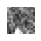

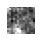

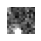

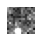

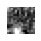

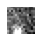

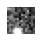

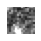

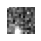

In [19]:
for f in frames:
    plt.figure(figsize=(0.5, 0.5))
    plt.axis("off")
    plt.imshow(model.control[offtarget, f].numpy(),
               vmin=vmin, vmax=vmax, cmap="gray")
    plt.savefig(f"/tmp/nondna{f}.png", dpi=600)
    plt.show()

### Figure 2

In [2]:
path_data = Path("/shared/centaur/data/GraceArticlePol2/")
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs16"

# load parameters
model = Cosmos(S=1, K=2)
model.load(path_data, True, "cpu")
model.load_parameters(path_params)

In [5]:
n = ontarget
f = 640

X = Y = np.arange(model.data.D) - (model.data.D - 1) / 2
X, Y = np.meshgrid(X, Y)

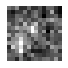

In [6]:
plt.figure(figsize=(1., 1.))
plt.imshow(model.data[n, f].numpy(), vmin=vmin, vmax=vmax, cmap="gray")
plt.axis("off")
plt.savefig("/tmp/obs2d.png", dpi=600)
plt.show()

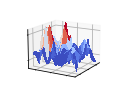

In [16]:
fig = plt.figure(figsize=(1.5, 1.5))
ax = fig.add_subplot(111, projection="3d")

Z = model.data[n, f].numpy()

# Plot the surface.
surf = ax.plot_surface(Y, X, Z, cmap=cm.coolwarm, vmin=450, vmax=570,
                       linewidth=0, antialiased=False)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
    
ax.view_init(elev=15., azim=30)
ax.set_zlim(vmin, vmax)

plt.savefig("/tmp/obs3d.png", dpi=600)

plt.show()

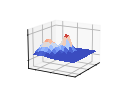

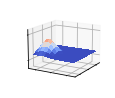

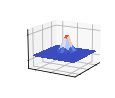

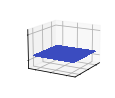

In [17]:
for m1, m2 in ((0, 0), (0, 1), (1, 0), (1, 1)):
    fig = plt.figure(figsize=(1.5, 1.5))
    ax = fig.add_subplot(111, projection="3d")

    img_ideal = model.data.offset_mean + pyro.param("d/b_loc").data[n, f:f+1, None, None]
    gaussian = model.data_loc(
        pyro.param("d/h_loc").data[:, n, f:f+1].masked_fill(torch.tensor([[m1], [m2]]), 0.),
        pyro.param("d/w_mean").data[:, n, f:f+1],
        pyro.param("d/x_mean").data[:, n, f:f+1],
        pyro.param("d/y_mean").data[:, n, f:f+1],
        n, torch.arange(f,f+1)
    )
    img_ideal = img_ideal + gaussian.sum(-4)
    Z = img_ideal[0].numpy()

    # Plot the surface.
    surf = ax.plot_surface(Y, X, Z, cmap=cm.coolwarm, vmin=450, vmax=570,
                           linewidth=0, antialiased=False)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.view_init(elev=15., azim=30)
    ax.set_zlim(vmin, vmax)

    plt.savefig(f"/tmp/image{m1}{m2}.png", dpi=600)
    plt.show()

### Figure 3

In [4]:
path_data = Path("/shared/centaur/data/GraceArticlePol2/")
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs16"

# load parameters
model = Cosmos(S=1, K=2)
model.load(path_data, True, "cpu")
model.load_parameters(path_params)

In [5]:
n = ontarget = 163
offtarget = 282
frames = [625, 628, 630, 633 , 635, 638, 640, 643, 645]
vmin, vmax = 340, 635

In [6]:
model.n = torch.tensor([n])
trace = pyro.poutine.trace(model.guide).get_trace()

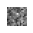

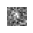

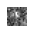

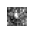

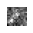

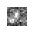

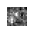

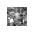

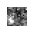

In [7]:
for f in frames:
    plt.figure(figsize=(0.35, 0.35))
    plt.axis("off")
    plt.imshow(model.data[ontarget, f].numpy(),
               vmin=vmin, vmax=vmax, cmap="gray")
    # plt.savefig(f"/home/ordabayev/repos/tapqir-overleaf/figures/figure3/grace-aois-{f}.png", dpi=600)
    plt.show()

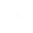

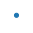

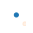

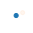

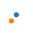

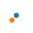

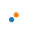

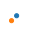

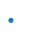

In [8]:
for f in frames:
    fig = plt.figure(figsize=(0.35, 0.35))

    plt.imshow(np.ones((model.data.D, model.data.D)),
               vmin=0, vmax=1, cmap="gray")
    # add patch
    for k in range(2):
        plt.gca().add_patch(
            Circle(
                (model.data.target_locs[n, f, 1] +
                 pyro.param("d/y_mean")[k, n, f].item(),
                 model.data.target_locs[n, f, 0] +
                 pyro.param("d/x_mean")[k, n, f].item()),
                1.5, color=f"C{k}", alpha=model.m_probs[k, n, f].item()
            )
        )
    plt.axis("off")
    # plt.savefig(f"/home/ordabayev/repos/tapqir-overleaf/figures/figure3/grace-{f}.png", dpi=600)
    plt.show()

In [9]:
f1, f2 = 625, 646

model.n = torch.tensor([n])
trace = pyro.poutine.trace(model.guide).get_trace()

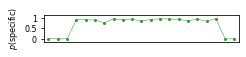

In [10]:
plt.figure(figsize=(3.5,0.5))

plt.plot(
    np.arange(f1, f2),
    model.z_marginal[n, f1:f2],
    "o-", ms=2, lw=0.5, color="C2", label="on-target"
)
#plt.plot(
#    np.arange(f1, f2),
#    1 - (1 - model.j_probs[:, n, f1:f2]).prod(0),
#    "o-", ms=2, lw=0.5, color="C3", label="off-target"
#)
plt.xticks([])
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p(\mathrm{specific})$", fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/grace-pspecific.svg")
plt.show()

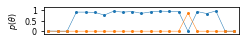

In [11]:
plt.figure(figsize=(3.5,0.5))

plt.plot(
    np.arange(f1, f2),
    model.z_probs[0, n, f1:f2],
    "o-", ms=2, lw=0.5, color="C0", label=r"$\theta=1$"
)
plt.plot(
    np.arange(f1, f2),
    model.z_probs[1, n, f1:f2],
    "o-", ms=2, lw=0.5, color="C1", label=r"$\theta=2$"
)
plt.xticks([])
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p(\theta)$", fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/grace-theta.svg")
plt.show()

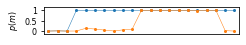

In [12]:
plt.figure(figsize=(3.5,0.5))

plt.plot(
    np.arange(f1, f2),
    model.m_probs[0, n, f1:f2],
    "o-", ms=2, lw=0.5, color="C0", label=r"$m_{1}$"
)
plt.plot(
    np.arange(f1, f2),
    model.m_probs[1, n, f1:f2],
    "o-", ms=2, lw=0.5, color="C1", label=r"$m_{2}$"
)
plt.xticks([])
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p(m)$", fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/grace-m.svg")
plt.show()

In [13]:
sites = [
    "d/height_0",
    "d/height_1",
    "d/width_0",
    "d/width_1",
    "d/x_0",
    "d/x_1",
    "d/y_0",
    "d/y_1",
    "d/background",
]
ci_stats = ci_from_trace(trace, sites)

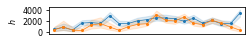

In [14]:
plt.figure(figsize=(3.5,0.5))

for k in range(2):
    plt.fill_between(
        np.arange(f1, f2),
        ci_stats[f"d/height_{k}"]["ll"][f1:f2], ci_stats[f"d/height_{k}"]["ul"][f1:f2],
        alpha=0.15, color=f"C{k}"
    )
    plt.plot(
        np.arange(f1, f2),
        ci_stats[f"d/height_{k}"]["mean"][f1:f2],
        "o-", ms=2, lw=0.7, color=f"C{k}",
    )

plt.xticks([])
plt.yticks([0, 2000, 4000], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-500, 4500)
plt.ylabel(r"$h$", fontsize=8)

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/grace-h.svg")
plt.show()

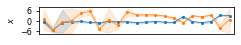

In [15]:
plt.figure(figsize=(3.5,0.5))

for k in range(2):
    plt.fill_between(
        np.arange(f1, f2),
        ci_stats[f"d/x_{k}"]["ll"][f1:f2], ci_stats[f"d/x_{k}"]["ul"][f1:f2],
        alpha=0.15, color=f"C{k}"
    )
    plt.plot(
        np.arange(f1, f2),
        ci_stats[f"d/x_{k}"]["mean"][f1:f2],
        "o-", ms=2, lw=0.7, color=f"C{k}",
    )

plt.xticks([])
plt.yticks([-6, 0, 6], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylabel(r"$x$", fontsize=8)

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/grace-x.svg")
plt.show()

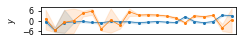

In [16]:
plt.figure(figsize=(3.5,0.5))

for k in range(2):
    plt.fill_between(
        np.arange(f1, f2),
        ci_stats[f"d/x_{k}"]["ll"][f1:f2], ci_stats[f"d/x_{k}"]["ul"][f1:f2],
        alpha=0.15, color=f"C{k}"
    )
    plt.plot(
        np.arange(f1, f2),
        ci_stats[f"d/x_{k}"]["mean"][f1:f2],
        "o-", ms=2, lw=0.7, color=f"C{k}",
    )

plt.xticks([])
plt.yticks([-6, 0, 6], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylabel(r"$y$", fontsize=8)

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/grace-y.svg")
plt.show()

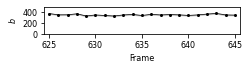

In [17]:
plt.figure(figsize=(3.5,0.5))

plt.plot(
    np.arange(f1, f2),
    ci_stats["d/background"]["mean"][f1:f2],
    "o-", ms=2, lw=0.7, color="k"
)
plt.fill_between(
    np.arange(f1, f2),
    ci_stats["d/background"]["ll"][f1:f2], ci_stats["d/background"]["ul"][f1:f2],
    alpha=0.15, color="k"
)

plt.xticks(np.arange(f1, f2+5, 5), fontsize=8)
plt.yticks([0, 200, 400], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(0, 500)
plt.ylabel(r"$b$", fontsize=8)
#plt.legend(fontsize=8)
plt.xlabel("Frame", fontsize=8)

plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/grace-b.svg")
plt.show()

### Figure 4

In [4]:
model.n = None
predictive = Predictive(pyro.poutine.uncondition(model.model), guide=model.guide, num_samples=1)
samples = predictive()

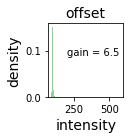

In [5]:
plt.figure(figsize=(1.35,1.35))
plt.hist(
        model.data.offset.flatten().numpy(),
        #range=(90, model.data.vmax+50),
        density=True, bins=20, alpha=0.5, color="C2", label="offset")
plt.text(200, 0.09, "gain = 6.5")
plt.title("offset", fontsize=14)
plt.ylabel("density", fontsize=14)
plt.xlabel("intensity", fontsize=14)
#plt.ylim(0,0.15)
plt.xlim(70, model.data.vmax+50)
#plt.legend()
#plt.tight_layout()
plt.show()

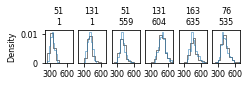

In [29]:
aois = [51, 131, 51, 131, 163, 76]
frames = [1, 1, 559, 604, 635, 535]

plt.figure(figsize=(3.5, 0.6))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    plt.title(f"{n}\n{f}", fontsize=8)
    plt.hist(
        model.data[n, f].flatten().numpy(),
        range=(200, model.data.vmax+150),
        density=True, bins=10, histtype="step", lw=0.5, color="k")
    plt.hist(
        samples["d/data"][0, n, f].flatten().numpy(),
        range=(200, model.data.vmax+150),
        density=True, bins=20, histtype="step", lw=0.5, color="C0")
    plt.xlim(200, model.data.vmax+150)
    plt.xticks([300, 600], fontsize=8)
    if i == 0:
        plt.yticks(fontsize=8)
        plt.ylabel("Density", fontsize=8)
        plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
    else:
        plt.yticks([])

# plt.tight_layout()
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure4/grace-hist.svg")

plt.show()

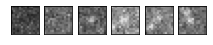

In [23]:
plt.figure(figsize=(3.5, 1))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    
    plt.imshow(model.data[n, f].numpy(), vmin=200, vmax=model.data.vmax+150, cmap="gray")
    plt.xticks([], [])
    plt.yticks([], [])

#plt.tight_layout()
# plt.colorbar()
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure4/grace-data.png", dpi=600)

plt.show()

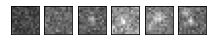

In [24]:
plt.figure(figsize=(3.5, 1))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    plt.imshow(samples["d/data"][0, n, f].numpy(), vmin=200, vmax=model.data.vmax+150, cmap="gray")
    plt.xticks([], [])
    plt.yticks([], [])

# plt.tight_layout()
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure4/grace-sample.png", dpi=600)

plt.show()

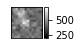

In [25]:
plt.figure(figsize=(0.7, 0.7))

plt.imshow(model.data[n, f].numpy(), vmin=200, vmax=model.data.vmax+150, cmap="gray")
plt.xticks([], [])
plt.yticks([], [])

#plt.tight_layout()
plt.colorbar(aspect=7, shrink=0.8)
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure4/grace-colorbar.svg")

plt.show()

### Figure 7

#### Spotpicker fit

In [29]:
path_data = Path("/shared/centaur/data/test/GraceArticlePol2/")
path_params = path_data / "runs/cosmosnojit/v1.1.6/S1/control/lr0.005/bs16"

# load parameters
model = Cosmos(S=1, K=2)
# model.load(path_data, True, "cpu")
model.device = torch.device("cpu")
model.data_path = Path(path_data)
model.load_parameters(path_params)

test_labels = np.load(path_data / "test_labels.npy")
control_labels = np.load(path_data / "control_labels.npy")
data = time_to_first_binding(test_labels["z"])
data = torch.tensor(data, dtype=torch.float)
control = time_to_first_binding(control_labels["z"])
control = torch.tensor(control, dtype=torch.float)
Tmax = model.z_map.shape[1]

train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=data, control=control, Tmax=Tmax
)

('ka: 0.03148037567734718', 'kns: 0.0063552530482411385', 'Af: 0.39005059003829956')
('ka: 0.022646082565188408', 'kns: 0.00449380511417985', 'Af: 0.3229425847530365')
('ka: 0.018795756623148918', 'kns: 0.0034302561543881893', 'Af: 0.29174819588661194')
('ka: 0.01723303832113743', 'kns: 0.0027669493574649096', 'Af: 0.28745806217193604')
('ka: 0.016292480751872063', 'kns: 0.0023250505328178406', 'Af: 0.30461516976356506')
('ka: 0.015023119747638702', 'kns: 0.0020147019531577826', 'Af: 0.33952319622039795')
('ka: 0.013347988948225975', 'kns: 0.0017868013819679618', 'Af: 0.3881300687789917')
('ka: 0.011637366376817226', 'kns: 0.0016130016883835196', 'Af: 0.44467848539352417')
('ka: 0.010186083614826202', 'kns: 0.0014764199731871486', 'Af: 0.5023948550224304')
('ka: 0.009097330272197723', 'kns: 0.0013668391620740294', 'Af: 0.5554481148719788')
('ka: 0.008335637860000134', 'kns: 0.0012778909876942635', 'Af: 0.6003280282020569')
('ka: 0.007815823890268803', 'kns: 0.001205387176014483', 'Af: 

In [30]:
from pyro.ops.stats import resample

In [31]:
# 1
new_data = resample(data, num_samples=len(data), replacement=True)
new_control = resample(control, num_samples=len(control), replacement=True)

train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=new_data, control=new_control, Tmax=Tmax
)

('ka: 0.031703006476163864', 'kns: 0.0063529047183692455', 'Af: 0.39105549454689026')
('ka: 0.023134425282478333', 'kns: 0.004486029036343098', 'Af: 0.32799217104911804')
('ka: 0.019322402775287628', 'kns: 0.0034161692019551992', 'Af: 0.30458179116249084')
('ka: 0.0175029169768095', 'kns: 0.0027458304539322853', 'Af: 0.31259778141975403')
('ka: 0.015891557559370995', 'kns: 0.0022960002534091473', 'Af: 0.34692785143852234')
('ka: 0.013875570148229599', 'kns: 0.0019766557961702347', 'Af: 0.40295353531837463')
('ka: 0.011947385966777802', 'kns: 0.001739010913297534', 'Af: 0.4723539650440216')
('ka: 0.01052330993115902', 'kns: 0.0015557961305603385', 'Af: 0.5420121550559998')
('ka: 0.009579947218298912', 'kns: 0.0014114476507529616', 'Af: 0.6012506484985352')
('ka: 0.00896697212010622', 'kns: 0.0012964281486347318', 'Af: 0.6468014121055603')
('ka: 0.008561278693377972', 'kns: 0.0012042457237839699', 'Af: 0.6803045272827148')
('ka: 0.008284102194011211', 'kns: 0.001130127115175128', 'Af: 0.

In [32]:
# 2
new_data = resample(data, num_samples=len(data), replacement=True)
new_control = resample(control, num_samples=len(control), replacement=True)

train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=new_data, control=new_control, Tmax=Tmax
)

('ka: 0.03218529373407364', 'kns: 0.006351914256811142', 'Af: 0.39127451181411743')
('ka: 0.02506459876894951', 'kns: 0.004483101423829794', 'Af: 0.3279787302017212')
('ka: 0.022996263578534126', 'kns: 0.003411494195461273', 'Af: 0.302215576171875')
('ka: 0.022357149049639702', 'kns: 0.0027402532286942005', 'Af: 0.3044174909591675')
('ka: 0.02097645029425621', 'kns: 0.002290997887030244', 'Af: 0.328389972448349')
('ka: 0.018707923591136932', 'kns: 0.001973984530195594', 'Af: 0.3692300021648407')
('ka: 0.01632729172706604', 'kns: 0.001740380423143506', 'Af: 0.42008665204048157')
('ka: 0.014311945997178555', 'kns: 0.0015623352956026793', 'Af: 0.4724608063697815')
('ka: 0.012765401974320412', 'kns: 0.0014233251567929983', 'Af: 0.5199440717697144')
('ka: 0.011630548164248466', 'kns: 0.0013130436418578029', 'Af: 0.5598471164703369')
('ka: 0.010807778686285019', 'kns: 0.0012246501864865422', 'Af: 0.5920605659484863')
('ka: 0.010206119157373905', 'kns: 0.0011533447541296482', 'Af: 0.617611110

In [33]:
# 3
new_data = resample(data, num_samples=len(data), replacement=True)
new_control = resample(control, num_samples=len(control), replacement=True)

train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=new_data, control=new_control, Tmax=Tmax
)

('ka: 0.03124258667230606', 'kns: 0.006355610676109791', 'Af: 0.3904224932193756')
('ka: 0.02202473394572735', 'kns: 0.004494736902415752', 'Af: 0.32527968287467957')
('ka: 0.017966821789741516', 'kns: 0.003431530436500907', 'Af: 0.2977210283279419')
('ka: 0.01631215587258339', 'kns: 0.002768106758594513', 'Af: 0.298660546541214')
('ka: 0.01536987442523241', 'kns: 0.0023254575207829475', 'Af: 0.3226096034049988')
('ka: 0.01422584243118763', 'kns: 0.0020137664396315813', 'Af: 0.36484748125076294')
('ka: 0.012828264385461807', 'kns: 0.0017843501409515738', 'Af: 0.41881757974624634')
('ka: 0.01148197241127491', 'kns: 0.0016094913007691503', 'Af: 0.47607752680778503')
('ka: 0.010379474610090256', 'kns: 0.0014728584792464972', 'Af: 0.5292491912841797')
('ka: 0.009561815299093723', 'kns: 0.0013644148129969835', 'Af: 0.5742889642715454')
('ka: 0.008986491709947586', 'kns: 0.001277615549042821', 'Af: 0.6101850271224976')
('ka: 0.008588637225329876', 'kns: 0.0012079108273610473', 'Af: 0.6377335

In [34]:
# 4
new_data = resample(data, num_samples=len(data), replacement=True)
new_control = resample(control, num_samples=len(control), replacement=True)

train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=new_data, control=new_control, Tmax=Tmax
)

('ka: 0.03168734163045883', 'kns: 0.006356907542794943', 'Af: 0.3896600306034088')
('ka: 0.02297675982117653', 'kns: 0.004499176051467657', 'Af: 0.3211689591407776')
('ka: 0.019137583673000336', 'kns: 0.003439462510868907', 'Af: 0.287986695766449')
('ka: 0.01761522889137268', 'kns: 0.0027798698283731937', 'Af: 0.280979186296463')
('ka: 0.0167077723890543', 'kns: 0.002341640880331397', 'Af: 0.2944823205471039')
('ka: 0.015429338440299034', 'kns: 0.0020349137485027313', 'Af: 0.3251505494117737')
('ka: 0.013765291310846806', 'kns: 0.001810508663766086', 'Af: 0.36974966526031494')
('ka: 0.012142777442932129', 'kns: 0.0016399824526160955', 'Af: 0.4226837158203125')
('ka: 0.010809819214046001', 'kns: 0.0015065587358549237', 'Af: 0.4763260781764984')
('ka: 0.009801280684769154', 'kns: 0.0014001931995153427', 'Af: 0.5244967937469482')
('ka: 0.009066133759915829', 'kns: 0.0013145721750333905', 'Af: 0.5644736289978027')
('ka: 0.008536840789020061', 'kns: 0.0012454004026949406', 'Af: 0.5962213873

In [35]:
# 5
new_data = resample(data, num_samples=len(data), replacement=True)
new_control = resample(control, num_samples=len(control), replacement=True)

train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=new_data, control=new_control, Tmax=Tmax
)

('ka: 0.031818948686122894', 'kns: 0.006354883313179016', 'Af: 0.3913579285144806')
('ka: 0.023925840854644775', 'kns: 0.004492602776736021', 'Af: 0.32857388257980347')
('ka: 0.021078472957015038', 'kns: 0.0034277087543159723', 'Af: 0.3038093149662018')
('ka: 0.02010589838027954', 'kns: 0.0027623630594462156', 'Af: 0.3077068030834198')
('ka: 0.01907571218907833', 'kns: 0.0023179759737104177', 'Af: 0.33368581533432007')
('ka: 0.01740656979382038', 'kns: 0.00200511422008276', 'Af: 0.37551233172416687')
('ka: 0.015444274060428143', 'kns: 0.00177530397195369', 'Af: 0.42576226592063904')
('ka: 0.013556605204939842', 'kns: 0.001600768300704658', 'Af: 0.47745591402053833')
('ka: 0.011951585300266743', 'kns: 0.0014647613279521465', 'Af: 0.5263729691505432')
('ka: 0.010723968036472797', 'kns: 0.001356735941953957', 'Af: 0.5701499581336975')
('ka: 0.00985230877995491', 'kns: 0.0012698855716735125', 'Af: 0.6071032881736755')
('ka: 0.009252100251615047', 'kns: 0.0011996554676443338', 'Af: 0.636660

In [16]:
# Tmax = model.data.F
nz = sum(data == 0)
n = sum(data == Tmax)
N = len(data)
tau = data[(data > 0) & (data < Tmax)]

nzc = sum(control == 0)
nc = sum(control == Tmax)
Nc = len(control)
tauc = control[(control > 0) & (control < Tmax)]

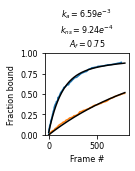

In [28]:
plt.figure(figsize=(1.5, 1.5))
x = torch.arange(Tmax)
plt.plot(sorted(data[data < Tmax]), np.arange(1, N+1-n) / N)
plt.plot(sorted(control[control < Tmax]), np.arange(1, Nc+1-nc) / Nc)
plt.plot(
    x,
    nzc / Nc +
    (1 - nzc / Nc) *
    (1 - np.exp(-pyro.param("kns").item() * x)),
    color="k"
)
plt.plot(
    x,
    nz / N +
    (1 - nz / N) *
    (pyro.param("Af").item()*(1 - np.exp(-(pyro.param("ka")+pyro.param("kns")).item() * x)) +
    (1 - pyro.param("Af").item())*(1 - np.exp(-pyro.param("kns").item() * x))),
    color="k"
)
plt.title(
    r"$k_a = 6.59e^{-3}$" + "\n" + r"$k_{ns} = 9.24e^{-4}$" + "\n" + r"$A_f = 0.75$",
    fontsize=8
)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("Frame #", fontsize=8)
plt.ylabel("Fraction bound", fontsize=8)
plt.ylim(0, 1)
plt.savefig("/tmp/gracearticlecy3-spotpicker.svg")
plt.show()

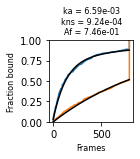

In [18]:
plt.figure(figsize=(1.5, 1.5))
x = torch.arange(model.data.F)
plt.plot(sorted(data), np.arange(1, N+1) / N)
plt.plot(sorted(control), np.arange(1, Nc+1) / Nc)
plt.plot(
    x,
    nzc / Nc +
    (1 - nzc / Nc) *
    (1 - np.exp(-pyro.param("kns").item() * x)),
    color="k"
)
plt.plot(
    x,
    nz / N +
    (1 - nz / N) *
    (pyro.param("Af").item()*(1 - np.exp(-(pyro.param("ka")+pyro.param("kns")).item() * x)) +
    (1 - pyro.param("Af").item())*(1 - np.exp(-pyro.param("kns").item() * x))),
    color="k"
)
plt.title(
    f"ka = {pyro.param('ka').item():.2e}\nkns = {pyro.param('kns').item():.2e}\nAf = {pyro.param('Af').item():.2e}",
    fontsize=8
)
plt.xlabel("Frames", fontsize=8)
plt.ylabel("Fraction bound", fontsize=8)
plt.ylim(0, 1)
plt.savefig("/tmp/gracearticlecy3-spotpicker.svg")
plt.show()

#### Spotpicker w/o control

In [19]:
path_data = Path("/shared/centaur/data/test/GraceArticlePol2/")
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs16"

# load parameters
model = Cosmos(S=1, K=2)
model.load(path_data, True, "cpu")
model.load_parameters(path_params)

data = time_to_first_binding(model.data.labels["z"])
data = torch.tensor(data, dtype=torch.float)
control = None
Tmax = model.data.F

train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=data, control=control, Tmax=Tmax
)

('ka: 0.03149029240012169', 'kns: 0.006429038476198912', 'Af: 0.3899784982204437')
('ka: 0.022708319127559662', 'kns: 0.004735735710710287', 'Af: 0.32174259424209595')
('ka: 0.0189275611191988', 'kns: 0.003851883113384247', 'Af: 0.2862306237220764')
('ka: 0.01753033883869648', 'kns: 0.0033565096091479063', 'Af: 0.27188563346862793')
('ka: 0.01711190678179264', 'kns: 0.0030627804808318615', 'Af: 0.27090105414390564')
('ka: 0.016870703548192978', 'kns: 0.0028779227286577225', 'Af: 0.2783072888851166')
('ka: 0.016457481309771538', 'kns: 0.0027523862663656473', 'Af: 0.2909170091152191')
('ka: 0.01584949716925621', 'kns: 0.0026585571467876434', 'Af: 0.30667993426322937')
('ka: 0.015145482495427132', 'kns: 0.0025810992810875177', 'Af: 0.3241930902004242')
('ka: 0.014433133415877819', 'kns: 0.0025120307691395283', 'Af: 0.34242725372314453')
('ka: 0.013760625384747982', 'kns: 0.0024476670660078526', 'Af: 0.3606415390968323')
('ka: 0.013148079626262188', 'kns: 0.002386649837717414', 'Af: 0.3783

('ka: 0.008649760857224464', 'kns: 0.0017091796034947038', 'Af: 0.5680540204048157')
('ka: 0.008649760857224464', 'kns: 0.0017091796034947038', 'Af: 0.5680540800094604')
('ka: 0.008649756200611591', 'kns: 0.001709178788587451', 'Af: 0.5680543184280396')


In [21]:
data = time_to_first_binding(model.data.labels["z"])
Tmax = model.data.F
nz = sum(data == 0)
n = sum(data == Tmax)
N = len(data)
tau = data[(data > 0) & (data < Tmax)]

control = time_to_first_binding(model.control.labels["z"])
nzc = sum(control == 0)
nc = sum(control == Tmax)
Nc = len(control)
tauc = control[(control > 0) & (control < Tmax)]

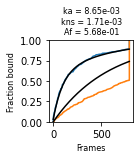

In [22]:
plt.figure(figsize=(1.5, 1.5))
x = torch.arange(model.data.F)
plt.plot(sorted(data), np.arange(1, N+1) / N)
plt.plot(sorted(control), np.arange(1, Nc+1) / Nc)
plt.plot(
    x,
    nzc / Nc +
    (1 - nzc / Nc) *
    (1 - np.exp(-pyro.param("kns").item() * x)),
    color="k"
)
plt.plot(
    x,
    nz / N +
    (1 - nz / N) *
    (pyro.param("Af").item()*(1 - np.exp(-(pyro.param("ka")+pyro.param("kns")).item() * x)) +
    (1 - pyro.param("Af").item())*(1 - np.exp(-pyro.param("kns").item() * x))),
    color="k"
)
plt.title(
    f"ka = {pyro.param('ka').item():.2e}\nkns = {pyro.param('kns').item():.2e}\nAf = {pyro.param('Af').item():.2e}",
    fontsize=8
)
plt.xlabel("Frames", fontsize=8)
plt.ylabel("Fraction bound", fontsize=8)
plt.ylim(0, 1)
plt.savefig("/tmp/gracearticlecy3-sp.svg")
plt.show()

#### Tapqir fit

In [2]:
path_data = Path("/shared/centaur/data/test/GraceArticlePol2/")
path_params = path_data / "runs/cosmosnojit/v1.1.6/S1/control/lr0.005/bs16"

# load parameters
model = Cosmos(S=1, K=2)
# model.load(path_data, True, "cpu")
model.device = torch.device("cpu")
model.data_path = Path(path_data)
model.load_parameters(path_params)

data = time_to_first_binding(model.z_map)
z_marginal = model.z_marginal.data
control = None
Tmax = model.z_map.shape[1]

train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=data, control=control, Tmax=Tmax
)

ka = []
kns = []
Af = []
ka.append(pyro.param("ka").item())
kns.append(pyro.param("kns").item())
Af.append(pyro.param("Af").item())

In [3]:
for i in range(100):
    z = dist.Bernoulli(z_marginal).sample()
    data = time_to_first_binding(z)

    train(
        ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
        data=data, control=control, Tmax=Tmax
    )
    ka.append(pyro.param("ka").item())
    kns.append(pyro.param("kns").item())
    Af.append(pyro.param("Af").item())

In [6]:
# ka
tapqir_ka = np.array(ka)
tapqir_ka.mean(), np.quantile(tapqir_ka, 0.16), np.quantile(tapqir_ka, 0.84)

(0.01002060576793876, 0.008511675521731377, 0.0113102151080966)

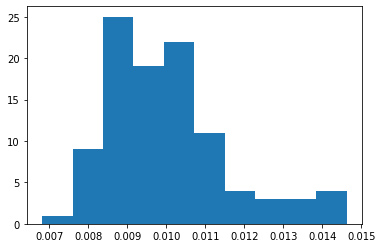

In [16]:
plt.hist(tapqir_ka)
plt.show()

In [13]:
# kns
tapqir_kns = np.array(kns)
tapqir_kns.mean(), np.quantile(tapqir_kns, 0.025), np.quantile(tapqir_kns, 0.975)

(0.0038638280342692638, 0.002111973939463496, 0.005580781493335962)

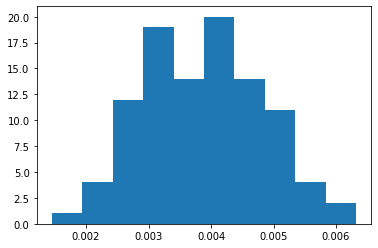

In [14]:
plt.hist(tapqir_kns)
plt.show()

In [9]:
# Af
tapqir_Af = np.array(Af)
tapqir_Af.mean(), np.quantile(tapqir_Af, 0.16), np.quantile(tapqir_Af, 0.84)

(0.6698158398123071, 0.5305742025375366, 0.7963463664054871)

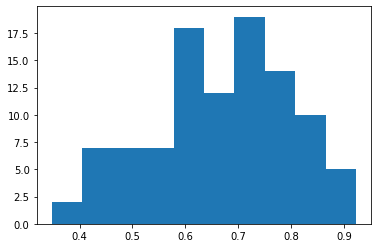

In [15]:
plt.hist(tapqir_Af)
plt.show()

In [15]:
# Tmax = model.data.F
nz = sum(data == 0)
n = sum(data == Tmax)
N = len(data)
tau = data[(data > 0) & (data < Tmax)]

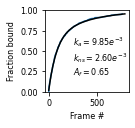

In [11]:
plt.figure(figsize=(1.5, 1.5))
x = torch.arange(Tmax)
plt.plot(sorted(data[data < Tmax]), np.arange(1, N+1-n) / N)
plt.plot(
    x,
    nz / N +
    (1 - nz / N) *
    (pyro.param("Af").item()*(1 - np.exp(-(pyro.param("ka")+pyro.param("kns")).item() * x)) +
    (1 - pyro.param("Af").item())*(1 - np.exp(-pyro.param("kns").item() * x))),
    color="k", label=""
)
plt.text(
    250, 0.2,
    s="$k_a = 9.85e^{-3}$\n$k_{ns} = 2.60e^{-3}$\n$A_f = 0.65$",
    fontsize=8
)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("Frame #", fontsize=8)
plt.ylabel("Fraction bound", fontsize=8)
plt.ylim(0, 1)
plt.savefig("/tmp/gracecy3sigma54-tapqir.svg")
plt.show()

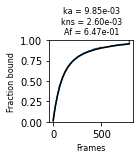

In [6]:
plt.figure(figsize=(1.5, 1.5))
x = torch.arange(model.data.F)
plt.plot(sorted(data), np.arange(1, N+1) / N)
plt.plot(
    x,
    nz / N +
    (1 - nz / N) *
    (pyro.param("Af").item()*(1 - np.exp(-(pyro.param("ka")+pyro.param("kns")).item() * x)) +
    (1 - pyro.param("Af").item())*(1 - np.exp(-pyro.param("kns").item() * x))),
    color="k"
)
plt.title(
    f"ka = {pyro.param('ka').item():.2e}\nkns = {pyro.param('kns').item():.2e}\nAf = {pyro.param('Af').item():.2e}",
    fontsize=8
)
plt.xlabel("Frames", fontsize=8)
plt.ylabel("Fraction bound", fontsize=8)
plt.ylim(0, 1)
plt.savefig("/tmp/gracecy3sigma54-tapqir.svg")
plt.show()

#### Rastegram

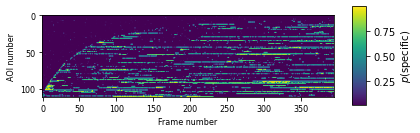

In [12]:
path_data = Path("/shared/centaur/data/test/GraceArticlePol2/")
path_params = path_data / "runs/cosmosnojit/v1.1.6/S1/control/lr0.005/bs16"

# load parameters
model = Cosmos(S=1, K=2)
# model.load(path_data, True, "cpu")
model.device = torch.device("cpu")
model.data_path = Path(path_data)
model.load_parameters(path_params)

ttfb = time_to_first_binding(model.z_map)
# sort ttfb
sdx = torch.argsort(ttfb, descending=True)


plt.figure(figsize=(6, 2))
plt.imshow(model.z_marginal[sdx][::3, ::2], aspect="equal")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("Frame number", fontsize=8)
plt.ylabel("AOI number", fontsize=8)
plt.colorbar(aspect=7, shrink=0.9, label=r"$p(\mathsf{specific})$")
plt.tight_layout()
plt.savefig("/tmp/gracearticlecy3-rastegram.png", dpi=900)
plt.show()

(array([4.87231e+05, 3.02600e+03, 1.68400e+03, 1.09300e+03, 7.49000e+02,
        5.65000e+02, 4.77000e+02, 4.08000e+02, 3.55000e+02, 3.31000e+02,
        3.68000e+02, 3.46000e+02, 4.34000e+02, 5.48000e+02, 6.57000e+02,
        8.77000e+02, 1.44700e+03, 2.73200e+03, 8.30700e+03, 1.13450e+04]),
 array([1.5643355e-06, 5.0000735e-02, 9.9999905e-02, 1.4999908e-01,
        1.9999824e-01, 2.4999742e-01, 2.9999658e-01, 3.4999576e-01,
        3.9999494e-01, 4.4999409e-01, 4.9999326e-01, 5.4999244e-01,
        5.9999162e-01, 6.4999080e-01, 6.9998997e-01, 7.4998915e-01,
        7.9998827e-01, 8.4998745e-01, 8.9998662e-01, 9.4998580e-01,
        9.9998498e-01], dtype=float32),
 <BarContainer object of 20 artists>)

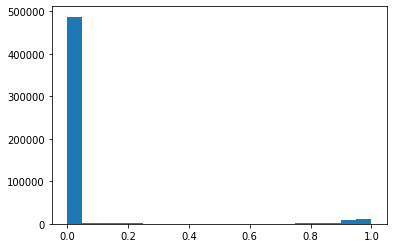

In [47]:
plt.hist(model.z_probs.numpy().ravel(), bins=20)

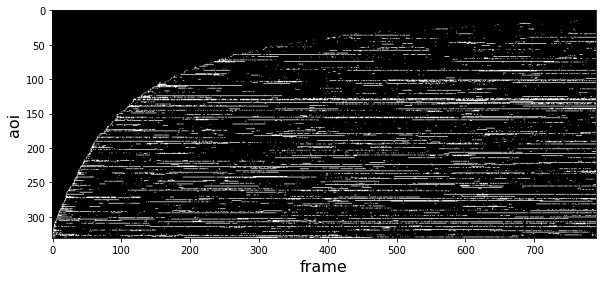

In [23]:
path_data = Path("/shared/centaur/data/test/GraceArticlePol2/")
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs16"

# load parameters
model = Cosmos(S=1, K=2)
model.load(path_data, True, "cpu")
model.load_parameters(path_params)

ttfb = time_to_first_binding(model.z_map)
# sort ttfb
sdx = torch.argsort(ttfb, descending=True)


figsize = torch.tensor([10, 10 * model.data.N / model.data.F])
plt.figure(figsize=figsize)
plt.imshow(model.z_map[sdx], cmap="gray")
plt.xlabel("frame", fontsize=16)
plt.ylabel("aoi", fontsize=16)
plt.show()

#### Dwell time fits

In [7]:
path_data = Path("/shared/centaur/data/test/GraceArticlePol2/")
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs16"

# load parameters
model = Cosmos(S=1, K=2)
model.load(path_data, True, "cpu")
model.load_parameters(path_params)

dt = unbound_dwell_times(count_intervals(model.z_map))
dt = torch.tensor(dt, dtype=torch.float)

train(
    double_exp_model, double_exp_guide, lr=5e-3, n_steps=5000,
    data=dt
)

('k1: 0.0634465366601944', 'k2: 0.6776713728904724', 'A: 0.6166990399360657')
('k1: 0.04465756565332413', 'k2: 0.606217086315155', 'A: 0.6679385900497437')
('k1: 0.03393048420548439', 'k2: 0.5849617719650269', 'A: 0.6922047734260559')
('k1: 0.027250204235315323', 'k2: 0.5705581903457642', 'A: 0.7073193788528442')
('k1: 0.02282271906733513', 'k2: 0.559715211391449', 'A: 0.7175983786582947')
('k1: 0.01975327730178833', 'k2: 0.5512570142745972', 'A: 0.7249632477760315')
('k1: 0.017554394900798798', 'k2: 0.544543445110321', 'A: 0.7304214835166931')
('k1: 0.015941420570015907', 'k2: 0.5391726493835449', 'A: 0.7345556020736694')
('k1: 0.014738448895514011', 'k2: 0.5348671078681946', 'A: 0.7377289533615112')
('k1: 0.01383170671761036', 'k2: 0.5314230918884277', 'A: 0.7401814460754395')
('k1: 0.01314433105289936', 'k2: 0.528683066368103', 'A: 0.742080569267273')
('k1: 0.012622607871890068', 'k2: 0.5265209078788757', 'A: 0.7435476779937744')
('k1: 0.012227648869156837', 'k2: 0.5248329043388367'

No handles with labels found to put in legend.


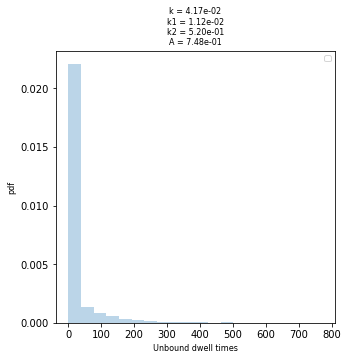

In [14]:
k = 1 / dt.mean()

plt.figure(figsize=(5, 5))
plt.title(
    f"k = {k:.2e}\nk1 = {pyro.param('k1').item():.2e}\nk2 = {pyro.param('k2').item():.2e}\nA = {pyro.param('A').item():.2e}",
    fontsize=8
)

plt.hist(dt.numpy(), bins=20, density=True, alpha=0.3)
x = torch.arange(0.01, dt.max())
d = dist.Exponential(k)
#plt.plot(x, d.log_prob(x).exp())
d1 = (1 - pyro.param("A").item())*(dist.Exponential(pyro.param("k1").item()).log_prob(x)).exp()
d2 = pyro.param("A").item()*(dist.Exponential(pyro.param("k2").item()).log_prob(x)).exp()
#plt.plot(x, d1, label="A1")
#plt.plot(x, d2, label="A2")
#plt.plot(x, d1+d2, label="At")
plt.xlabel("Unbound dwell times", fontsize=8)
plt.ylabel("pdf", fontsize=8)
#plt.ylim(0, 0.2)
#plt.xlim(0, 100)
plt.legend(fontsize=8)
plt.savefig("/tmp/gracecy3sigma54-kon.svg")
plt.show()

In [13]:
dt.max()

tensor(770.)

Time to first binding

$$ \mathrm{ttfb} = \sum_{f=1}^{F-1} f z_{n,f} \prod_{f^\prime=0}^{f-1} (1 - z_{n,f^\prime})
    + F \prod_{f^\prime=0}^{F-1} (1 - z_{n,f^\prime}) $$

$$ \mathbb{E}[\mathrm{ttfb}] = \sum_{f=1}^{F-1} f q(z_{n,f}=1) \prod_{f^\prime=f-1}^{f-1} q(z_{n,f^\prime}=0)
    + F \prod_{f^\prime=0}^{F-1} q(z_{n,f^\prime}=0) $$

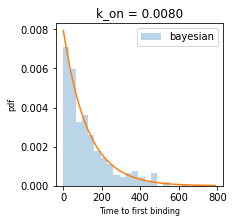

In [247]:
frames = torch.arange(1, model.data.F+1)
q1 = torch.ones(model.data.N, model.data.F)
q1[:, :-1] = model.z_marginal[:, 1:]
cumq0 = torch.cumprod(1 - model.z_marginal, dim=-1)
ttfb = (frames * q1 * cumq0).sum(-1)
kon = 1 / ttfb.mean()

plt.figure(figsize=(3, 3))
plt.title(f"k_on = {kon:.4f}")
plt.hist(ttfb.numpy(), bins=20, density=True, alpha=0.3, label="bayesian")
# plt.hist(sttfb, bins=20, density=True, alpha=0.3, label="spotpicker")
x = torch.arange(1,model.data.F)
d = dist.Exponential(kon)
plt.plot(x, d.log_prob(x).exp())
plt.xlabel("Time to first binding", fontsize=8)
plt.ylabel("pdf", fontsize=8)
plt.legend()
plt.show()

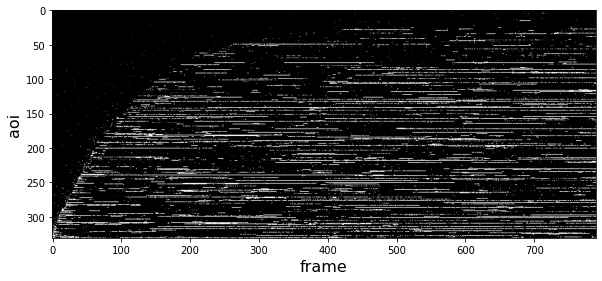

In [248]:
# sort ttfb
sdx = torch.argsort(ttfb, descending=True)

figsize = torch.tensor([10, 10 * model.data.N / model.data.F])
plt.figure(figsize=figsize)
plt.imshow(model.z_marginal[sdx], cmap="gray")
plt.xlabel("frame", fontsize=16)
plt.ylabel("aoi", fontsize=16)
plt.show()

0.5 cut-off

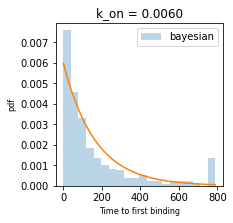

In [250]:
frames = torch.arange(1, model.data.F+1)
q1 = torch.ones(model.data.N, model.data.F)
q1[:, :-1] = model.z_map[:, 1:].long()
cumq0 = np.cumprod(1 - model.z_map.long(), axis=-1)
ttfb = (frames * q1 * cumq0).sum(-1)
kon = 1 / ttfb.mean()


plt.figure(figsize=(3, 3))
plt.title(f"k_on = {kon:.4f}")
plt.hist(ttfb.numpy(), bins=20, density=True, alpha=0.3, label="bayesian")
# plt.hist(sttfb, bins=20, density=True, alpha=0.3, label="spotpicker")
x = torch.arange(1,model.data.F)
d = dist.Exponential(kon)
plt.plot(x, d.log_prob(x).exp())
plt.xlabel("Time to first binding", fontsize=8)
plt.ylabel("pdf", fontsize=8)
plt.legend()
plt.show()

In [251]:
ttfb

tensor([ 19.,  84.,  34.,  52.,  10.,   4., 176.,  14., 118.,  52., 790.,  78.,
        347.,  52., 417., 317.,  56.,   8., 753., 360.,  63.,  20.,  92., 104.,
          9.,  57., 131., 440., 155.,  94., 112.,  78.,  23.,   3., 206., 115.,
         32., 194.,  32., 117.,  81.,  94., 234., 261.,  76., 139., 761., 380.,
        110., 288., 214., 120.,  38., 309., 168.,  94.,   7.,  38., 132., 101.,
          0., 278.,  65.,  72., 790.,  15.,  92., 192., 152.,  42., 123.,  49.,
         60.,   0.,  30.,  18.,  24.,  37.,   2.,   1.,   2.,  46., 221., 145.,
        398., 418., 137., 647.,  45.,  18., 142.,  27.,  32., 405., 596., 790.,
        187.,  75.,  65., 118., 107.,  41., 439., 220.,  67.,   3.,  20.,  55.,
        790.,  50.,  56.,  63.,  33.,   4., 171.,   1., 192.,   8.,  22.,  14.,
         12., 259.,  17.,   8., 263.,  26.,   0., 474.,   9., 477.,  29.,  98.,
         50.,  46.,  41., 187.,  76., 369.,  86.,  78.,  88.,  59., 790., 600.,
          0., 252.,  16.,  69., 326.,  7

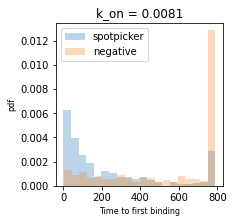

In [149]:
plt.figure(figsize=(3, 3))
plt.title(f"k_on = {kon:.4f}")
# plt.hist(ttfb.numpy(), bins=20, density=True, alpha=0.3, label="bayesian")
plt.hist(sttfb, bins=20, density=True, alpha=0.3, label="spotpicker")
plt.hist(nttfb, bins=20, density=True, alpha=0.3, label="negative")
x = torch.arange(1,model.data.F)
d = dist.Exponential(kon)
# plt.plot(x, d.log_prob(x).exp())
plt.xlabel("Time to first binding", fontsize=8)
plt.ylabel("pdf", fontsize=8)
plt.legend()
plt.show()

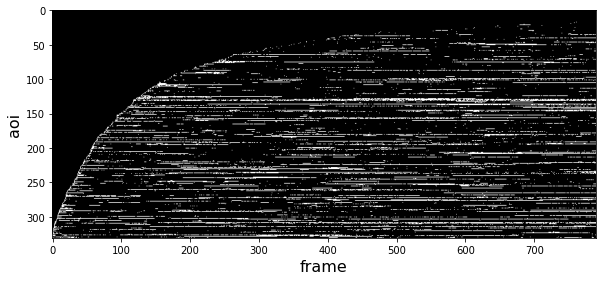

In [113]:
# sort ttfb
sdx = torch.argsort(ttfb, descending=True)

figsize = torch.tensor([10, 10 * model.data.N / model.data.F])
plt.figure(figsize=figsize)
plt.imshow(model.z_map[sdx], cmap="gray")
plt.xlabel("frame", fontsize=16)
plt.ylabel("aoi", fontsize=16)
plt.show()

In [114]:
path_data = Path("/shared/centaur/data/test/GraceNegative/")
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs16"

# load parameters
negative = Cosmos(S=1, K=2)
negative.load(path_data, True, "cpu")
negative.load_parameters(path_params)

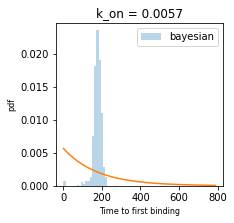

In [115]:
frames = torch.arange(1, negative.data.F+1)
q1 = torch.ones(negative.data.N, negative.data.F)
q1[:, :-1] = negative.z_marginal[:, 1:]
cumq0 = torch.cumprod(1 - negative.z_marginal, dim=-1)
ttfb = (frames * q1 * cumq0).sum(-1)
kon = 1 / ttfb.mean()

plt.figure(figsize=(3, 3))
plt.title(f"k_on = {kon:.4f}")
plt.hist(ttfb.numpy(), bins=20, density=True, alpha=0.3, label="bayesian")
# plt.hist(sttfb, bins=20, density=True, alpha=0.3, label="spotpicker")
x = torch.arange(1,negative.data.F)
d = dist.Exponential(kon)
plt.plot(x, d.log_prob(x).exp())
plt.xlabel("Time to first binding", fontsize=8)
plt.ylabel("pdf", fontsize=8)
plt.legend()
plt.show()

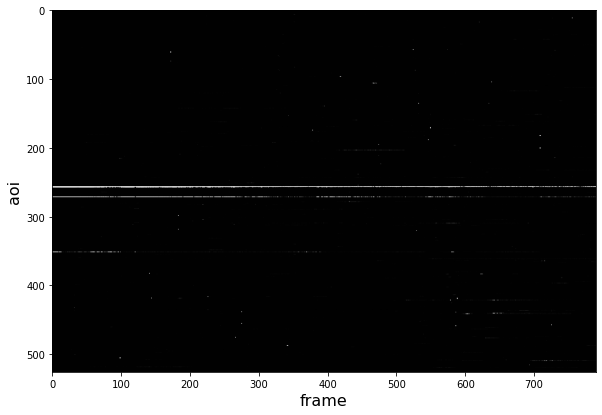

In [118]:
# sort ttfb
sdx = torch.argsort(ttfb, descending=True)

figsize = torch.tensor([10, 10 * negative.data.N / negative.data.F])
plt.figure(figsize=figsize)
plt.imshow(negative.z_marginal, cmap="gray", vmin=0, vmax=1)
plt.xlabel("frame", fontsize=16)
plt.ylabel("aoi", fontsize=16)
plt.show()

In [12]:
frames = np.arange(1, model.data.F+1)
q1 = np.ones((negative.data.N, negative.data.F))
q1[:, :-1] = negative.data.labels["z"][:, 1:]
cumq0 = np.cumprod(1 - negative.data.labels["z"], axis=-1)
nttfb = (frames * q1 * cumq0).sum(-1)

NameError: name 'negative' is not defined

0.0042929030919277855


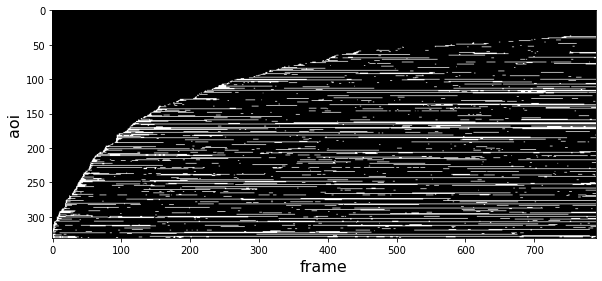

In [170]:
frames = np.arange(1, model.data.F+1)
q1 = np.ones((model.data.N, model.data.F))
q1[:, :-1] = model.data.labels["z"][:, 1:]
cumq0 = np.cumprod(1 - model.data.labels["z"], axis=-1)
sttfb = (frames * q1 * cumq0).sum(-1)
print(1/sttfb.mean())
sdx = np.flip(np.argsort(sttfb))

plt.figure(figsize=figsize)

plt.imshow(model.data.labels["z"][sdx], cmap="gray")
plt.xlabel("frame", fontsize=16)
plt.ylabel("aoi", fontsize=16)
plt.show()

In [229]:
Tmax = model.data.F
n = sum(sttfb == Tmax)
nz = sum(sttfb == 0)
N = model.data.N
tau = torch.tensor(sttfb[(sttfb < Tmax) & (sttfb > 0)])
kns.item()

0.0009126707445830107

In [233]:
def ll(k, a):
    result = n * torch.log((a - nz/N) * torch.exp(-(k+kns.item()) * Tmax) + (1-a)*math.exp(-kns.item()*Tmax)) \
    + torch.sum(torch.log((a-nz/N)*(k+kns.item())*torch.exp(-(k+kns.item())*tau)+(1-a)*kns.item()*torch.exp(-kns.item()*tau)))
    return result

lr = 1e-4
ks = torch.tensor(0.01, requires_grad=True)
Af = torch.tensor(0.5, requires_grad=True)
optimizer = torch.optim.Adam((ks,Af), lr=lr)
ks, ks.grad

(tensor(0.0100, requires_grad=True), None)

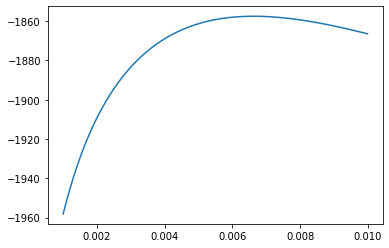

In [239]:
x = torch.arange(1e-3, 0.01, 1e-5)
plt.plot(x, [ll(i, torch.tensor(0.75)) for i in x])
plt.show()

In [242]:
for t in range(2000):

    # Compute and print loss.
    loss = -ll(ks, Af)
    if t % 100 == 99:
        print(t, loss.item(), ks.item(), Af.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

99 1857.5488349537914 0.006566280033439398 0.7559651136398315
199 1857.5488306411976 0.0065665352158248425 0.7559650540351868
299 1857.5488424254809 0.0065630036406219006 0.7559651136398315
399 1857.5488209296798 0.006566187366843224 0.7559652328491211
499 1857.5488238157943 0.006564036011695862 0.7559651136398315
599 1857.5488140725515 0.006566272117197514 0.7559651732444763
699 1857.5488283650038 0.006565968040376902 0.7559652328491211
799 1857.5488206506618 0.006565637420862913 0.7559652328491211
899 1857.5488162763645 0.006566251628100872 0.7559652328491211
999 1857.5488601810857 0.006561477668583393 0.7559651732444763
1099 1857.5488346743239 0.006566159892827272 0.7559652924537659
1199 1857.5488322655392 0.006564874667674303 0.7559650540351868
1299 1857.5488147220115 0.006566253490746021 0.7559651732444763
1399 1857.5488298009798 0.006569304969161749 0.7559651732444763
1499 1857.5488244341786 0.006566233932971954 0.7559652924537659
1599 1857.548873726765 0.006572341546416283 0.755

In [178]:
n, nz, N

(37, 10, 331)

In [138]:
Tmax = model.control.F
nc = sum(sttfb == Tmax)
Nc = model.control.N
tauc = torch.tensor(sttfb[sttfb < Tmax])
kns = (Nc - nc) / (nc*Tmax + sum(tauc))

In [141]:
def LL(k):
    return - nc*k*Tmax + (torch.log(k) - k * tauc).sum()

lr = 1e-4
kns = torch.tensor(0.01, requires_grad=True)
optimizer = torch.optim.Adam((kns,), lr=lr)
kns, kns.grad

(tensor(0.0100, requires_grad=True), None)

In [142]:
for t in range(2000):

    # Compute and print loss.
    loss = -LL(kns)
    if t % 100 == 99:
        print(t, loss.item(), kns.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

99 2136.350866954541 0.0009742508409544826
199 2135.7691805949435 0.0009123082272708416
299 2135.7691876465688 0.000912663817871362
399 2135.769199164235 0.0009126708027906716
499 2135.7691787867807 0.0009126707445830107
599 2135.7691787867807 0.0009126707445830107
699 2135.7691787867807 0.0009126707445830107
799 2135.7691787867807 0.0009126707445830107
899 2135.7691787867807 0.0009126707445830107
999 2135.7691787867807 0.0009126707445830107
1099 2135.7691787867807 0.0009126707445830107
1199 2135.7691787867807 0.0009126707445830107
1299 2135.7691787867807 0.0009126707445830107
1399 2135.7691787867807 0.0009126707445830107
1499 2135.7691787867807 0.0009126707445830107
1599 2135.7691787867807 0.0009126707445830107
1699 2135.7691787867807 0.0009126707445830107
1799 2135.7691787867807 0.0009126707445830107
1899 2135.7691787867807 0.0009126707445830107
1999 2135.7691787867807 0.0009126707445830107


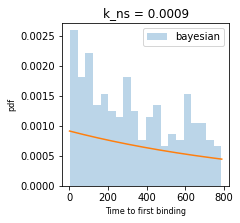

In [38]:
plt.figure(figsize=(3, 3))
plt.title(f"k_ns = {kns:.4f}")
plt.hist(tau, bins=20, density=True, alpha=0.3, label="bayesian")
# plt.hist(sttfb, bins=20, density=True, alpha=0.3, label="spotpicker")
x = torch.arange(1, model.control.F)
d = dist.Exponential(kns)
plt.plot(x, d.log_prob(x).exp())
plt.xlabel("Time to first binding", fontsize=8)
plt.ylabel("pdf", fontsize=8)
plt.legend()
plt.show()

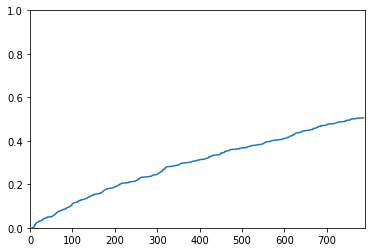

In [36]:
plt.plot(sorted(tau), np.arange(Nc - nc) / Nc)
plt.plot()
plt.xlim(0, model.control.F)
plt.ylim(0, 1)
plt.show()

0.0017979955426118107


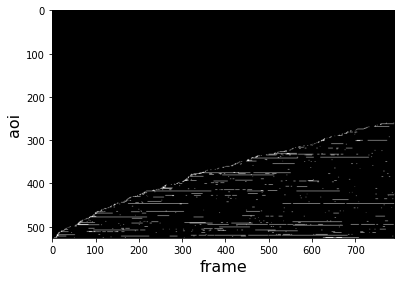

In [136]:
frames = np.arange(1, model.control.F+1)
q1 = np.ones((model.control.N, model.control.F))
q1[:, :-1] = model.control.labels["z"][:, 1:]
cumq0 = np.cumprod(1 - model.control.labels["z"], axis=-1)
sttfb = (frames * q1 * cumq0).sum(-1)
print(1/sttfb.mean())
sdx = np.flip(np.argsort(sttfb))

plt.figure(figsize=figsize)

plt.imshow(model.control.labels["z"][sdx], cmap="gray")
plt.xlabel("frame", fontsize=16)
plt.ylabel("aoi", fontsize=16)
plt.show()

### HMM

In [129]:
path_data = Path("/shared/centaur/data/test/GraceArticlePol2/")
path_params = path_data / "runs/hmm/v1.1.6/S1/control/lr0.005/bs16"

# load parameters
hmm = HMM(S=1, K=2)
hmm.load(path_data, True, "cpu")
hmm.load_parameters(path_params)

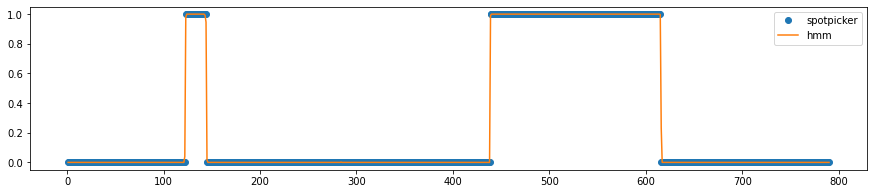

In [132]:
n = 9
plt.figure(figsize=(15,3))
plt.plot(hmm.data.drift.index, hmm.data.labels["z"][n], "o", label="spotpicker")
plt.plot(hmm.data.drift.index, hmm.z_marginal[n], "-", label="hmm")
plt.legend()
plt.show()

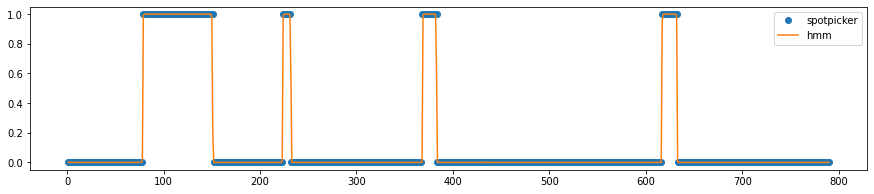

In [133]:
n = 11
plt.figure(figsize=(15,3))
plt.plot(hmm.data.drift.index, hmm.data.labels["z"][n], "o", label="spotpicker")
plt.plot(hmm.data.drift.index, hmm.z_marginal[n], "-", label="hmm")
plt.legend()
plt.show()

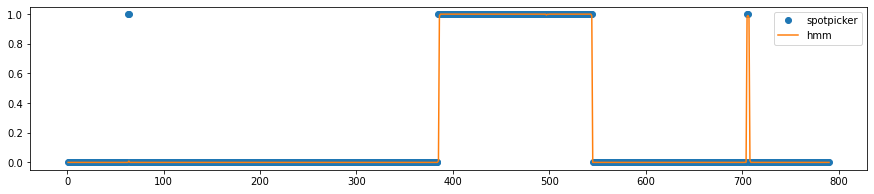

In [134]:
n = 20
plt.figure(figsize=(15,3))
plt.plot(hmm.data.drift.index, hmm.data.labels["z"][n], "o", label="spotpicker")
plt.plot(hmm.data.drift.index, hmm.z_marginal[n], "-", label="hmm")
plt.legend()
plt.show()

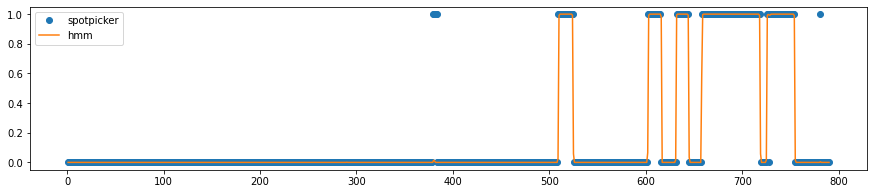

In [137]:
n = 12
plt.figure(figsize=(15,3))
plt.plot(hmm.data.drift.index, hmm.data.labels["z"][n], "o", label="spotpicker")
plt.plot(hmm.data.drift.index, hmm.z_marginal[n], "-", label="hmm")
plt.legend()
plt.show()

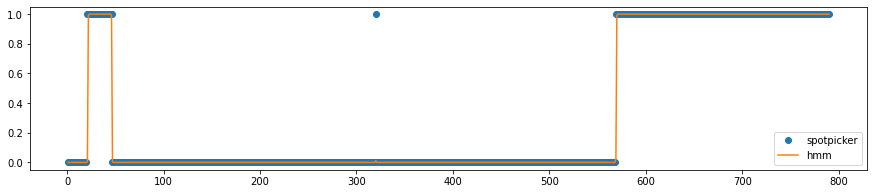

In [139]:
n = 150
plt.figure(figsize=(15,3))
plt.plot(hmm.data.drift.index, hmm.data.labels["z"][n], "o", label="spotpicker")
plt.plot(hmm.data.drift.index, hmm.z_marginal[n], "-", label="hmm")
plt.legend()
plt.show()

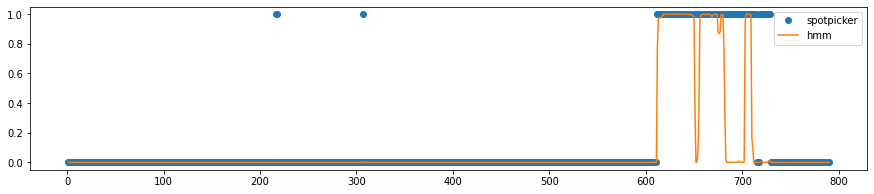

In [140]:
n = 200
plt.figure(figsize=(15,3))
plt.plot(hmm.data.drift.index, hmm.data.labels["z"][n], "o", label="spotpicker")
plt.plot(hmm.data.drift.index, hmm.z_marginal[n], "-", label="hmm")
plt.legend()
plt.show()

## Analysis

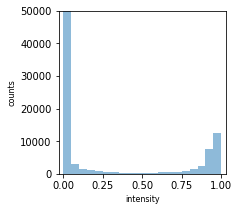

In [42]:
plt.figure(figsize=(3, 3))
plt.hist(model.z_probs.flatten().numpy(),
         bins=20, alpha=0.5)
plt.ylim(0,50000)
plt.xlim(-0.03,1.03)
plt.ylabel("counts", fontsize=8)
plt.xlabel("intensity", fontsize=8)
plt.show()

### Intensity analysis

Intensity histogram (on-target spots)

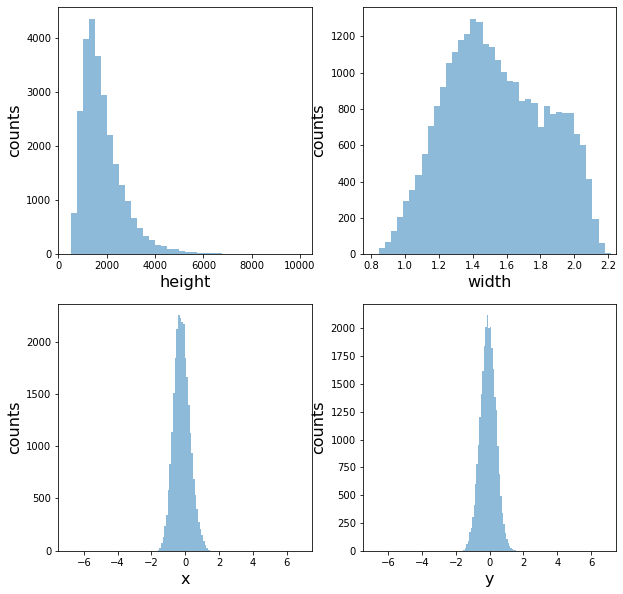

In [44]:
plt.figure(figsize=(10,10))
mask = model.z_probs > 0.5
plt.subplot(2,2,1)
plt.hist(pyro.param("d/h_loc").data[mask].numpy(),
         range=(0,10000), bins=40, alpha=0.5)
plt.xlim(0,)
plt.ylabel("counts", fontsize=16)
plt.xlabel("height", fontsize=16)

plt.subplot(2,2,2)
plt.hist(pyro.param("d/w_mean").data[mask].numpy(),
         bins=40, alpha=0.5)
plt.xlim(0.75,2.25)
plt.ylabel("counts", fontsize=16)
plt.xlabel("width", fontsize=16)

plt.subplot(2,2,3)
plt.hist(pyro.param("d/x_mean").data[mask].numpy(),
         bins=40, alpha=0.5)
plt.xlim(-7.5,7.5)
plt.ylabel("counts", fontsize=16)
plt.xlabel("x", fontsize=16)

plt.subplot(2,2,4)
plt.hist(pyro.param("d/y_mean").data[mask].numpy(),
         bins=40, alpha=0.5)
plt.xlim(-7.5,7.5)
plt.ylabel("counts", fontsize=16)
plt.xlabel("y", fontsize=16)
plt.show()

### Binding rastergram

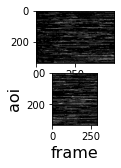

In [104]:
r = model.data.F // 500 + 1
figsize = torch.tensor([5, 5 * model.data.N / model.data.F])
plt.figure(figsize=figsize)
for i in range(r):
    plt.subplot(r,1,i+1)
    plt.imshow(model.z_marginal[:, i*500:(i+1)*500], cmap="gray")
plt.xlabel("frame", fontsize=16)
plt.ylabel("aoi", fontsize=16)
plt.show()

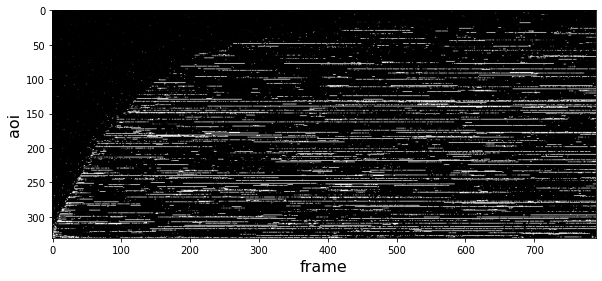

In [106]:
# sort ttfb
sdx = torch.argsort(ttfb, descending=True)

figsize = torch.tensor([10, 10 * model.data.N / model.data.F])
plt.figure(figsize=figsize)
#for i in range(r):
#    plt.subplot(r,1,i+1)
#    plt.imshow(model.z_marginal[sdx, i*500:(i+1)*500], cmap="gray")
plt.imshow(model.z_marginal[sdx], cmap="gray")
plt.xlabel("frame", fontsize=16)
plt.ylabel("aoi", fontsize=16)
plt.show()

### HMM analysis


$$ A_{01} = \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} \dfrac{(1-z_{n,f-1}) z_{n,f}}{\sum_{n^\prime=0}^{N-1} \sum_{f^\prime=1}^{F-1} (1-z_{n^\prime,f^\prime-1})} $$

$$ A_{10} = \dfrac{\sum_n^N \sum_f^F z_{n,f} (1-z_{n,f+1})}{\sum_n^N \sum_f^F z_{n,f}} $$

In [93]:
samples = dist.Bernoulli(model.z_marginal).sample((100,))

bind = (samples[..., :-1] < samples[..., 1:]).sum((-1))
dissociate = (samples[..., :-1] > samples[..., 1:]).sum(-1)

a01 = ((1 - samples[..., :-1]) * samples[..., 1:] / (1-samples[..., :-1]).sum((-2,-1), keepdim=True)).sum((-2,-1))
a10 = ((samples[..., :-1]) * (1 - samples[..., 1:]) / (samples[..., :-1]).sum((-2,-1), keepdim=True)).sum((-2,-1))

sa01 = ((1 - model.data.labels["z"][:, :-1]) * model.data.labels["z"][:, 1:] / (1-model.data.labels["z"][:, :-1]).sum((-2,-1), keepdims=True)).sum((-2,-1))
sa10 = ((model.data.labels["z"][:, :-1]) * (1 - model.data.labels["z"][:, 1:]) / (model.data.labels["z"][:, :-1]).sum((-2,-1), keepdims=True)).sum((-2,-1))

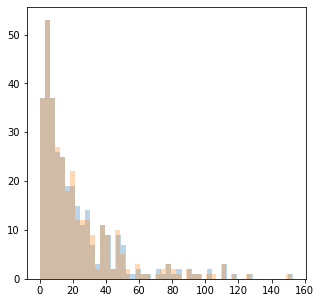

In [94]:
plt.figure(figsize=(5,5))
plt.hist(bind[0].numpy(), bins=50, alpha=0.3)
plt.hist(dissociate[0].numpy(), bins=50, alpha=0.3)
#plt.xlim(0,60)
plt.show()

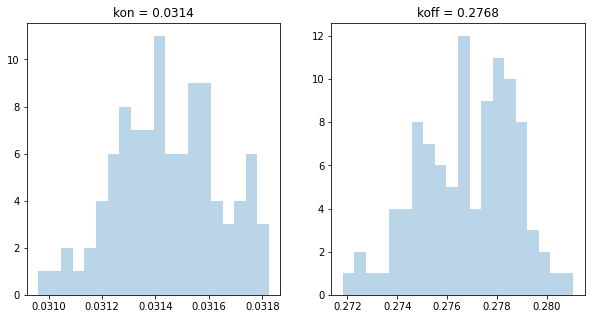

In [95]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(a01.flatten().numpy(), bins=20, alpha=0.3)
plt.title("kon = {:.4f}".format(a01.mean()))
plt.subplot(1,2,2)
plt.hist(a10.flatten().numpy(), bins=20, alpha=0.3)
plt.title("koff = {:.4f}".format(a10.mean()))
plt.show()

Let's find and remove high-frequency traces

/home/ordabayev/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  """Entry point for launching an IPython kernel.


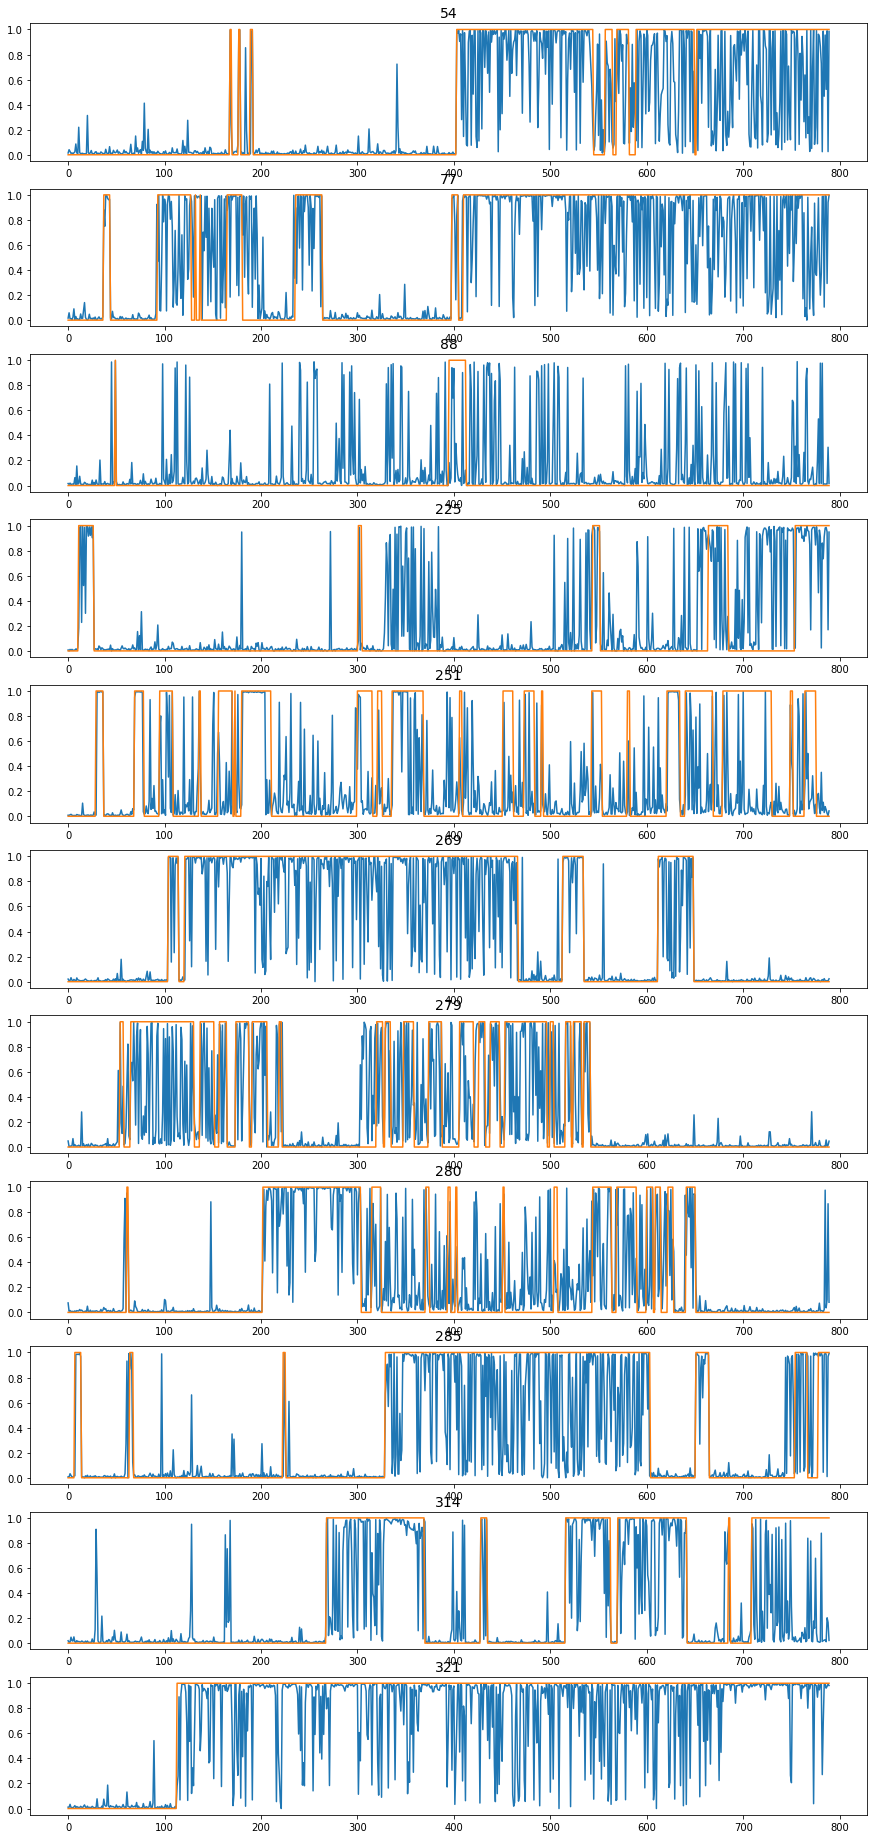

In [17]:
high_frequency = torch.nonzero(bind[0] > 80).squeeze()
r = len(high_frequency) + 1
plt.figure(figsize=(15,3*r))
for i, n in enumerate(high_frequency):
    plt.subplot(r,1,i+1)
    plt.title(n.item(), fontsize=14)
    plt.plot(model.z_marginal[n])
    plt.plot(model.data.labels["z"][n])
plt.show()

In [18]:
low_frequency = torch.nonzero(bind[0] <= 80).squeeze()
a01 = ((1 - samples[:, low_frequency, :-1]) * samples[:, low_frequency, 1:] / (1-samples[:, low_frequency, :-1]).sum((-2,-1), keepdim=True)).sum((-2,-1))
a10 = ((samples[:, low_frequency, :-1]) * (1 - samples[:, low_frequency, 1:]) / (samples[:, low_frequency, :-1]).sum((-2,-1), keepdim=True)).sum((-2,-1))

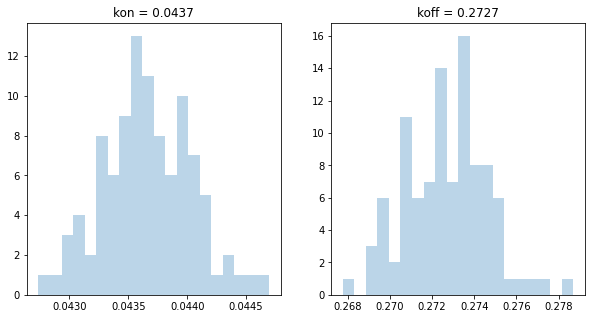

In [19]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(a01.flatten().numpy(), bins=20, alpha=0.3)
plt.title("kon = {:.4f}".format(a01.mean()))
plt.subplot(1,2,2)
plt.hist(a10.flatten().numpy(), bins=20, alpha=0.3)
plt.title("koff = {:.4f}".format(a10.mean()))
plt.show()

In [20]:
sa01, sa10

(0.005810791090120329, 0.03622816032887975)

Now let's see how real data kinetics compares to the simulated kinetics from the best fit

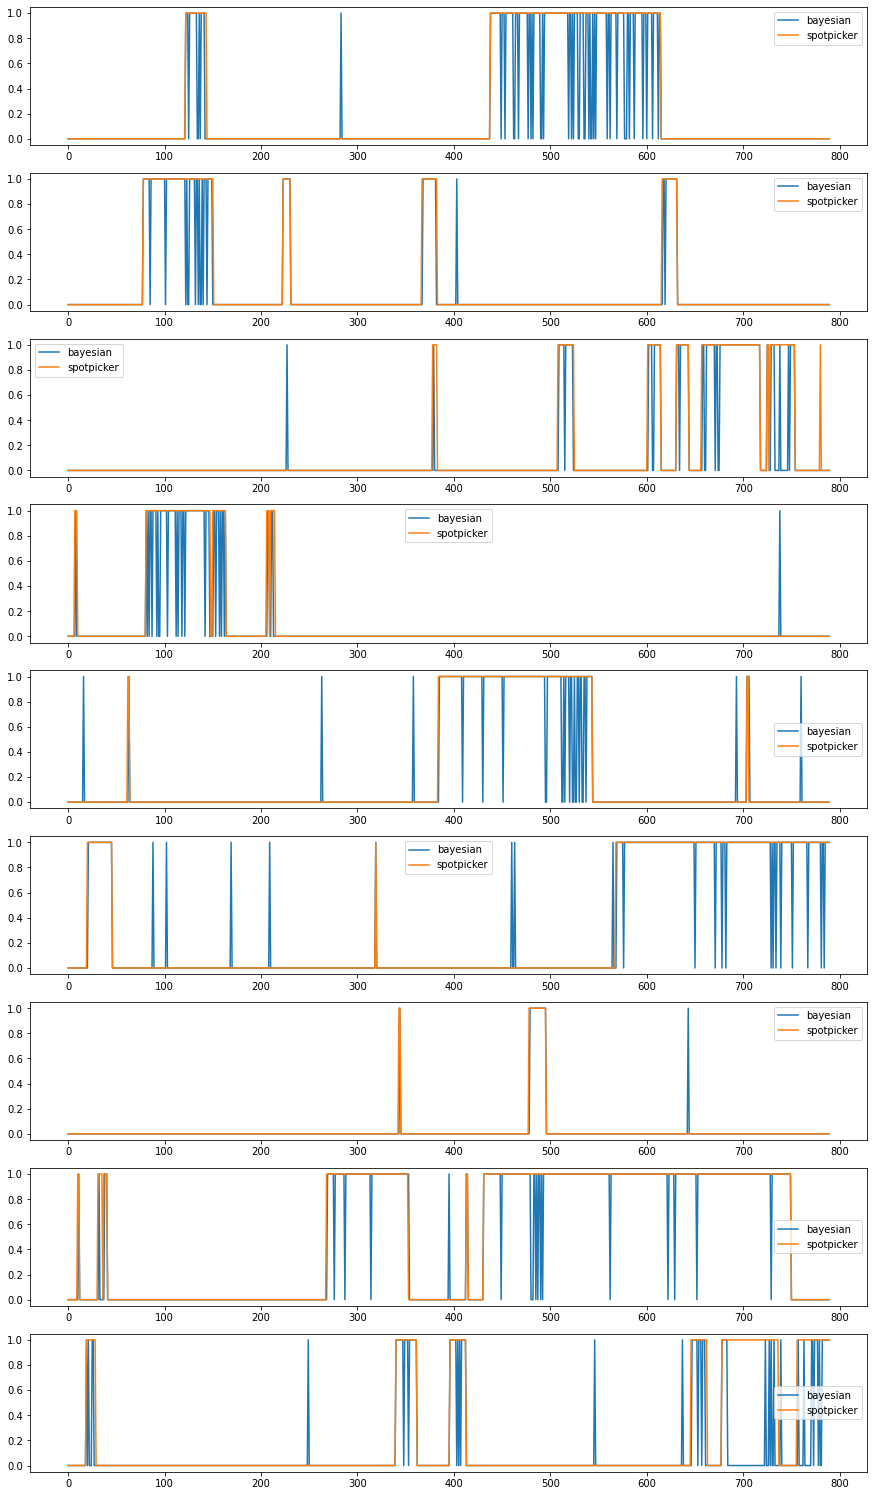

In [20]:
# look at 5, 15, 30, 35
examples = [9, 11, 12, 17, 20, 150, 160, 170, 311]
r = len(examples) + 1
plt.figure(figsize=(15,3*r))
for i, n in enumerate(examples):
    plt.subplot(r,1,i+1)
    plt.plot(z_map[n], label="bayesian")
    plt.plot(model.data.labels["z"][n], label="spotpicker")
    plt.legend()
plt.show()

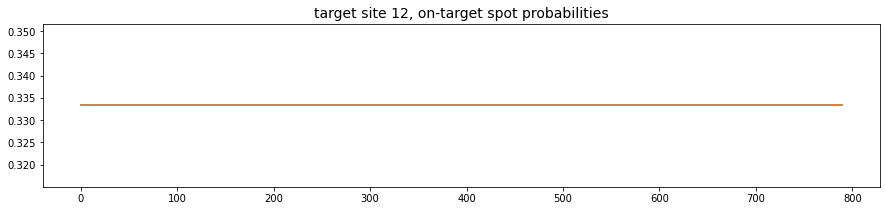

In [7]:
n = 12
plt.figure(figsize=(15,3))
plt.title("target site {}, on-target spot probabilities".format(n), fontsize=14)
plt.plot(model.z_probs[0, n, :].data)
plt.plot(model.z_probs[1, n, :].data)

plt.show()

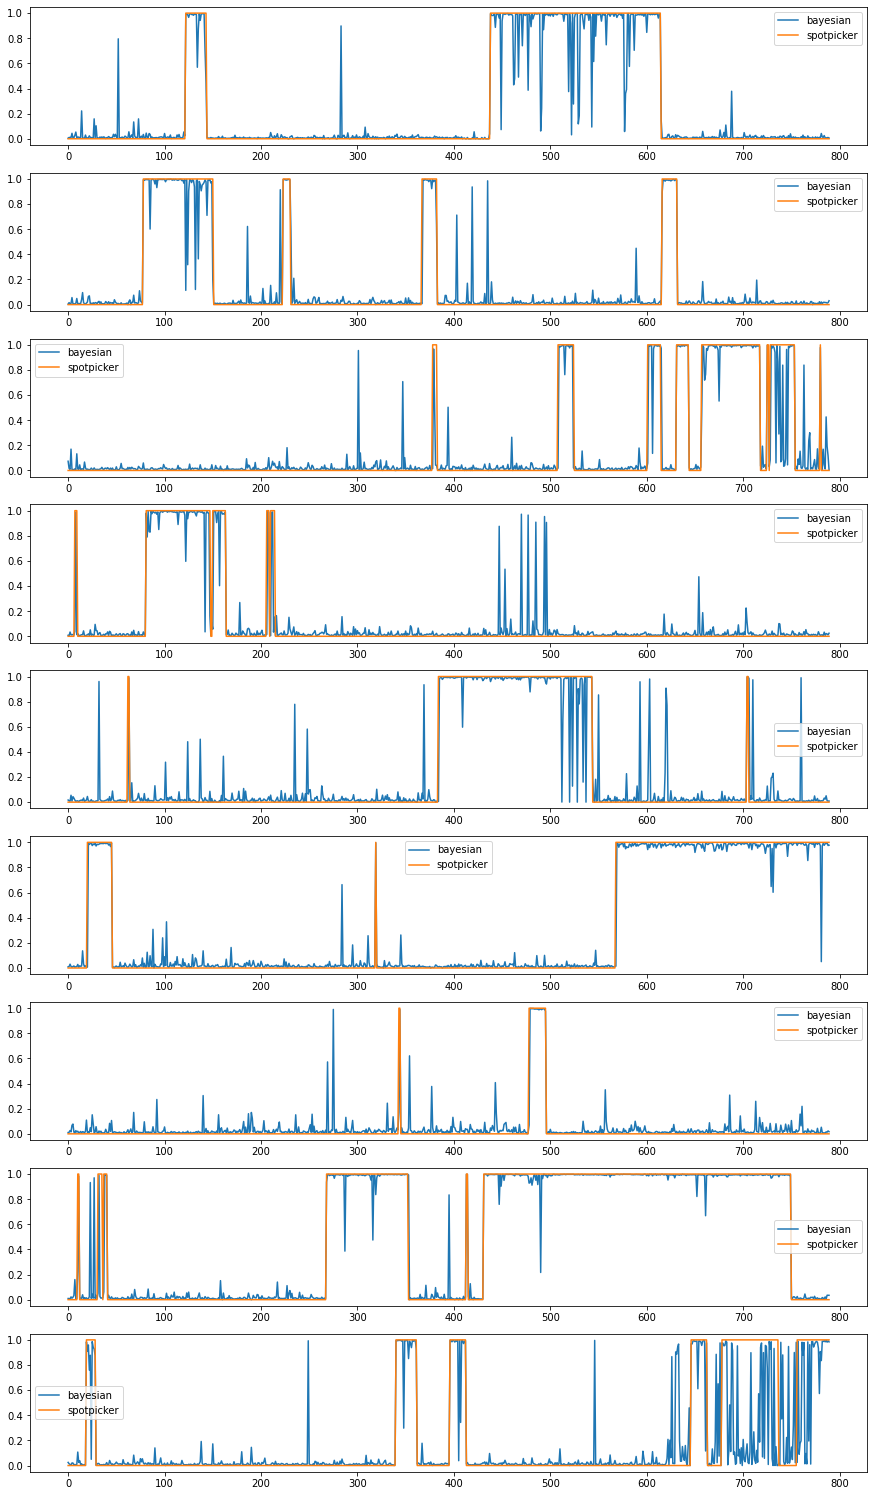

In [21]:
# look at 5, 15, 30, 35
examples = [9, 11, 12, 17, 20, 150, 160, 170, 311]
r = len(examples) + 1
plt.figure(figsize=(15,3*r))
for i, n in enumerate(examples):
    plt.subplot(r,1,i+1)
    plt.plot(model.z_marginal[n], label="bayesian")
    plt.plot(model.data.labels["z"][n], label="spotpicker")
    plt.legend()
plt.show()

### Simulated trace

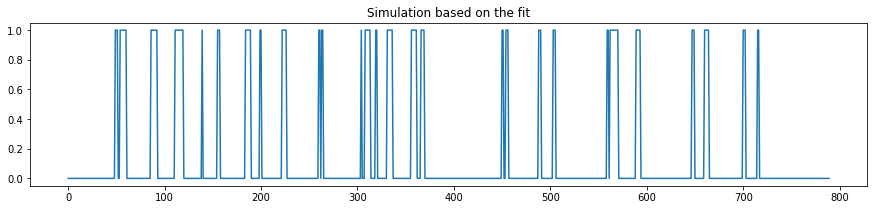

In [22]:
A = torch.tensor([[1-a01.mean(), a01.mean()], [a10.mean(), 1-a10.mean()]])

x = torch.zeros(model.data.F)
for i in range(1,model.data.F):
    x[i] = dist.Bernoulli(A[x[i-1].long()][1]).sample().item()

plt.figure(figsize=(15,3))
plt.title("Simulation based on the fit")
plt.plot(x)
plt.show()

### Spotpicker sorted rastergram

0.0042929030919277855


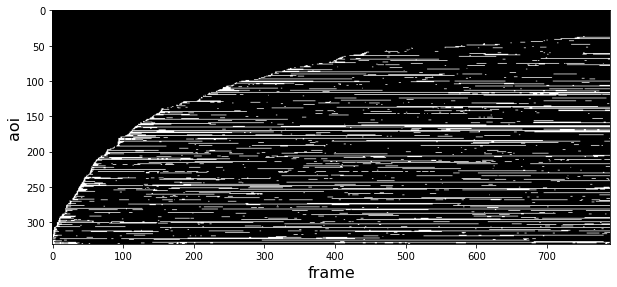

In [143]:
frames = np.arange(1, model.data.F+1)
q1 = np.ones((model.data.N, model.data.F))
q1[:, :-1] = model.data.labels["z"][:, 1:]
cumq0 = np.cumprod(1 - model.data.labels["z"], axis=-1)
sttfb = (frames * q1 * cumq0).sum(-1)
print(1/sttfb.mean())
sdx = np.flip(np.argsort(sttfb))

r = model.data.F // 500 + 1
#figsize = torch.tensor([15, model.data.N * r * 15. / 500])
plt.figure(figsize=figsize)
#for i in range(r):
#    plt.subplot(r,1,i+1)
#    plt.imshow(model.data.labels["z"][sdx, i*500:(i+1)*500], cmap="gray")

plt.imshow(model.data.labels["z"][sdx], cmap="gray")
plt.xlabel("frame", fontsize=16)
plt.ylabel("aoi", fontsize=16)
plt.show()

### Differences

torch.Size([3065, 14, 14])


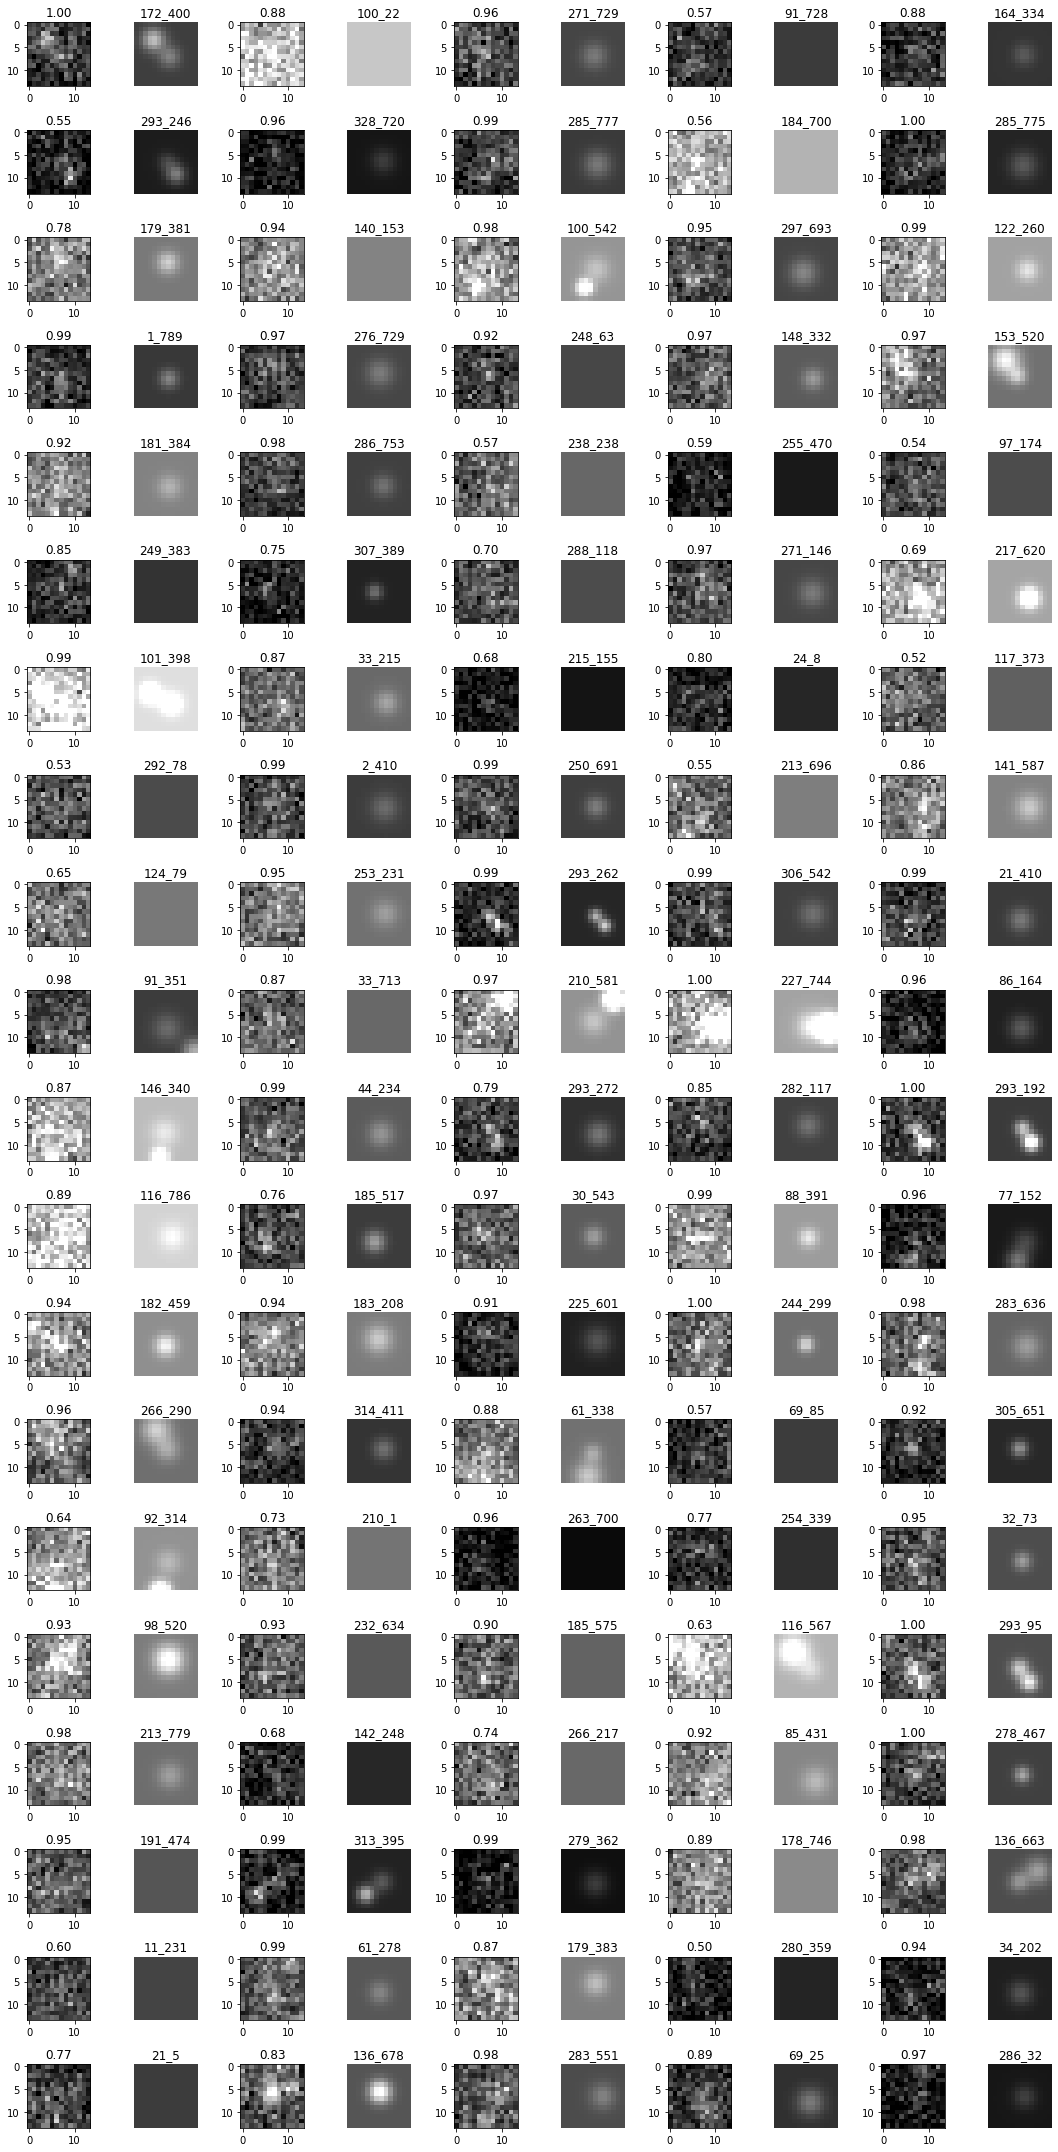

In [24]:
# spots missed by cosmos
mask = (((model.data.labels["z"] == 0) & (model.z_marginal.numpy() > 0.5)))

n, f = np.nonzero(mask)
idx = np.arange(len(n))
np.random.shuffle(idx)

result = model.data.data[mask.astype("bool"), :, :]
print(result.shape)

plt.figure(figsize=(15,30))
for i in range(min(100, len(result))):
    j = idx[i]
    plt.subplot(20, 10, 2*i+1)
    
    gaussians = model.data_loc(
    param("d/h_loc").data[:, n[j], f[j]].masked_fill(model.m_probs[:, n[j], f[j]] < 0.5, 0.),
    param("d/w_mean").data[:, n[j], f[j]],
    param("d/x_mean").data[:, n[j], f[j]],
    param("d/y_mean").data[:, n[j], f[j]],
    n[j], f[j]).sum(-3)
    ideal = model.offset_mean + param("d/b_loc").data[n[j], f[j]] + gaussians
    plt.imshow(result[j].numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    plt.title("{:.2f}".format(model.z_marginal[n[j], f[j]]))
    
    plt.subplot(20, 10, 2*i+2)
    plt.title(f"{n[j]}_{f[j]}")
    plt.imshow(ideal.numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    plt.axis('off')
plt.tight_layout()
plt.show()

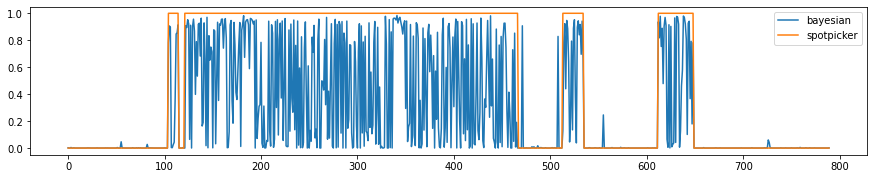

In [100]:
# look at 5, 15, 30, 35
examples = [269]
r = len(examples) + 1
plt.figure(figsize=(15,3*r))
for i, n in enumerate(examples):
    plt.subplot(r,1,i+1)
    f1 = 2500
    f2 = 2600
    #plt.plot(torch.arange(f1, f2), model.z_marginal[n, f1:f2], label="bayesian")
    #plt.plot(torch.arange(f1, f2), model.data.labels["z"][n, f1:f2], label="spotpicker")
    plt.plot(torch.arange(model.data.F), model.z_marginal[n], label="bayesian")
    plt.plot(torch.arange(model.data.F), model.data.labels["z"][n], label="spotpicker")
    plt.legend()
plt.show()

torch.Size([4625, 14, 14])


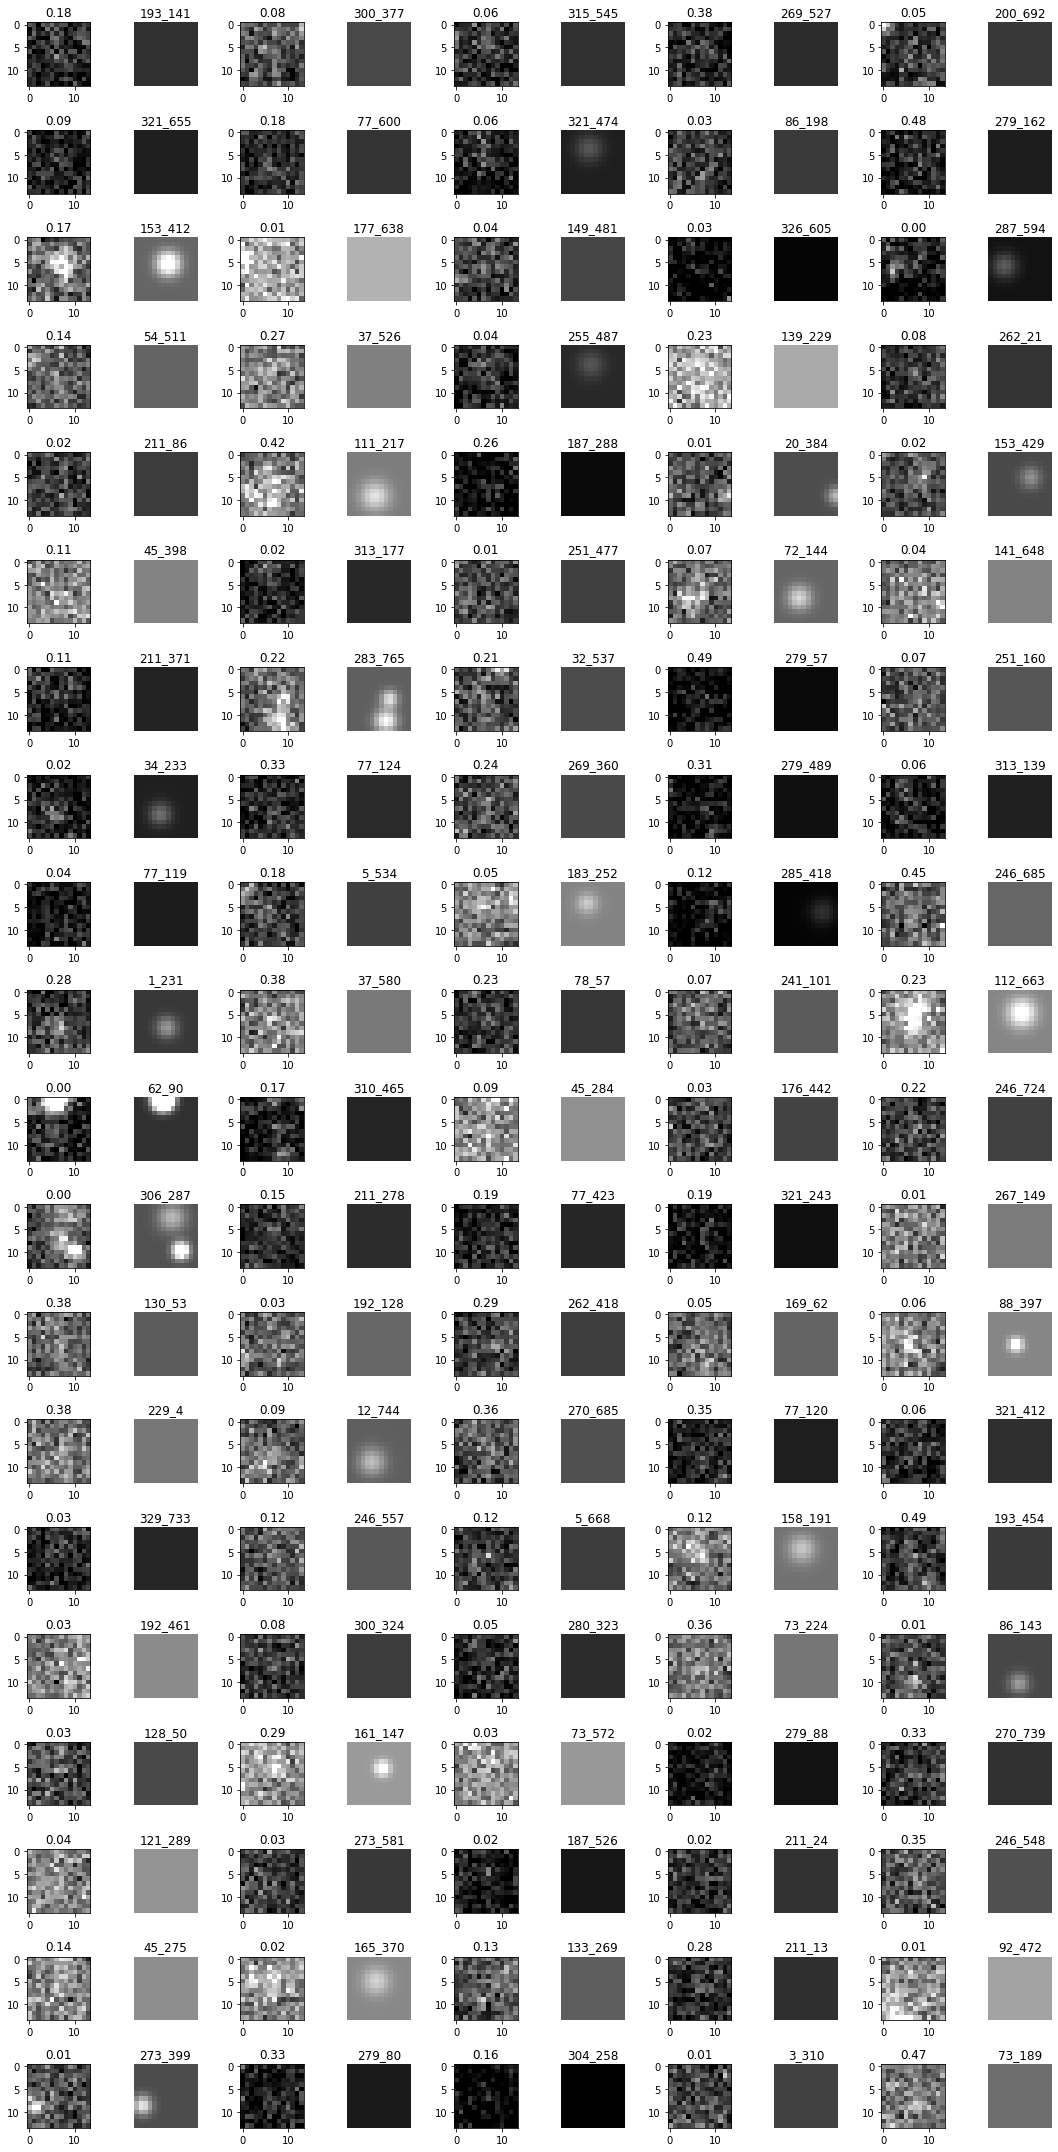

In [26]:
# spots missed by cosmos
mask = (((model.data.labels["z"] == 1) & (model.z_marginal.numpy() < 0.5)))

n, f = np.nonzero(mask)
idx = np.arange(len(n))
np.random.shuffle(idx)

result = model.data.data[mask.astype("bool"), :, :]
print(result.shape)

plt.figure(figsize=(15,30))
for i in range(min(100, len(result))):
    j = idx[i]
    plt.subplot(20, 10, 2*i+1)
    
    gaussians = model.data_loc(
    param("d/h_loc").data[:, n[j], f[j]].masked_fill(model.m_probs[:, n[j], f[j]] < 0.5, 0.),
    param("d/w_mean").data[:, n[j], f[j]],
    param("d/x_mean").data[:, n[j], f[j]],
    param("d/y_mean").data[:, n[j], f[j]],
    n[j], f[j]).sum(-3)
    ideal = model.offset_mean + param("d/b_loc").data[n[j], f[j]] + gaussians
    plt.imshow(result[j].numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    plt.title("{:.2f}".format(model.z_marginal[n[j], f[j]]))
    
    plt.subplot(20, 10, 2*i+2)
    plt.title(f"{n[j]}_{f[j]}")
    plt.imshow(ideal.numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Appendix

$$ p(\mathbf{z}) = \prod_{n=0}^{N-1} p(z_{n,0}|\pi) \prod_{f=1}^{F-1} p(z_{n,f}|z_{n,f-1}, A) $$

$$ \log p(\mathbf{z}) = \sum_{n=0}^{N-1} \left ( \log p(z_{n,0}|\pi) + \sum_{f=1}^{F-1} \log p(z_{n,f}|z_{n,f-1}, A_{01}, A_{10}) \right ) $$

$$ \log p(\mathbf{z}) = \sum_{n=0}^{N-1} \left ( (1-z_{n,0}) \log (1-\pi) + z_{n,0} \log \pi +
    \sum_{f=1}^{F-1} \left (
        (1 - z_{n,f-1}) (1 - z_{n,f}) \log (1 - \frac{A_{01}}{2})
        + (1-z_{n,f-1}) z_{n,f} \log \frac{A_{01}}{2}
        + z_{n,f-1} (1 - z_{n,f}) \log \frac{1+A_{10}}{2}
        + z_{n,f-1} z_{n,f} \log (1 - A_{10}) \right ) \right ) $$

$$ \log p(\mathbf{z}) = \sum_{n=0}^{N-1} \left ( (1-z_{n,0}) \log (1-\pi) + z_{n,0} \log \pi +
    \sum_{f=1}^{F-1} \left (
        (1 - z_{n,f-1}) (1 - z_{n,f}) \log (1 - A_{01})
        + (1-z_{n,f-1}) z_{n,f} \log A_{01}
        + z_{n,f-1} (1 - z_{n,f}) \log A_{10}
        + z_{n,f-1} z_{n,f} \log (1 - A_{10}) \right ) \right ) $$

$$ \dfrac{\partial \log p(\mathbf{z})}{\partial \pi}
 = \sum_{n=0}^{N-1} \left ( -\dfrac{1-z_{n,0}}{1-\pi} + \dfrac{z_{n,0}}{\pi} \right ) = 0 $$
 
$$ \sum_{n=0}^{N-1} \left ( \dfrac{(1-\pi) z_{n,0} - \pi (1-z_{n,0})}{\pi (1-\pi)} \right ) = 0 $$

$$ \dfrac{\partial \log p(\mathbf{z})}{\partial A_{01}}
 = \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} \left (
     \dfrac{-(1-z_{n,f-1})(1-z_{n,f})}{1-A_{01}}
     + \dfrac{(1-z_{n,f-1})z_{n,f}}{A_{01}} \right ) = 0 $$

$$ \sum_{n=0}^{N-1} \left ( z_{n,0} - \pi \right ) = 0 $$

$$ \pi = \dfrac{1}{N} \sum_{n=0}^{N-1} z_{n,0} $$

$$ \mathbb{E}_{q(\mathbf{z})} \left [ \pi \right ] = \dfrac{1}{N} \sum_{n=0}^{N-1} q(z_{n,0}=1) $$

$$ \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} \left ( (1-A_{01}) (1-z_{n,f-1})z_{n,f} - A_{01} (1-z_{n,f-1})(1-z_{n,f}) \right ) = 0 $$

$$ \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} (1-z_{n,f-1}) z_{n,f} - \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} (1-z_{n,f-1}) A_{01} = 0 $$

$$ \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} (1-z_{n,f-1}) z_{n,f} = \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} (1-z_{n,f-1}) A_{01} $$

$$ A_{01} = \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} \dfrac{(1-z_{n,f-1}) z_{n,f}}{\sum_{n^\prime=0}^{N-1} \sum_{f^\prime=1}^{F-1} (1-z_{n^\prime,f^\prime-1})} $$

$$ A_{10} = \dfrac{\sum_n^N \sum_f^F z_{n,f} (1-z_{n,f+1})}{\sum_n^N \sum_f^F z_{n,f}} $$

$$ \mathbb{E}_{q(\mathbf{z})} \left [ A_{01} \right ]
    = \sum_\mathbf{z} \sum_n^N \sum_f^F \dfrac{(1-z_{n,f}) z_{n,f+1}}{\sum_{n^\prime}^N \sum_{f^\prime}^F (1-z_{n^\prime,f^\prime})} q(\mathbf{z}) $$

$$  = \sum_n^N \sum_f^F q(z_{n,f}=0) q(z_{n,f+1}=1) \sum_{\mathbf{z} \backslash z_{n,f},z_{n,f+1}}
    \dfrac{1}{1 + 0 + \sum_{n^\prime}^N \sum_{f^\prime}^F (1-z_{n^\prime,f^\prime})} q(\mathbf{z}) $$